## Setting up a machine learning environment

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
import os
import joblib
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn

from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, cross_validate
from sklearn.utils import resample
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import  cross_validate
from catboost import CatBoostClassifier
from pandas.plotting import table
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef, confusion_matrix
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier




pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

/Users/Internship/Documents/GitHub/Capstone_Notebook/env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## To run the mlflow

In [2]:
#  mlflow ui --host 0.0.0.0 --port 5001

# Loading the datasets into dataframes

In [3]:
df_fridayAF_DDos = pd.read_csv("../datasets/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")
df_fridayAF_PortScan = pd.read_csv("../datasets/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv")
df_fridayMO = pd.read_csv("../datasets/Friday-WorkingHours-Morning.pcap_ISCX.csv")
df_monday = pd.read_csv("../datasets/Monday-WorkingHours.pcap_ISCX.csv")
df_thursdayAF_Infilteration = pd.read_csv("../datasets/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv")
df_thursdayMO_WebAttacks = pd.read_csv("../datasets/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv")
df_tuesday = pd.read_csv("../datasets/Tuesday-WorkingHours.pcap_ISCX.csv")
df_wednesday = pd.read_csv("../datasets/Wednesday-workingHours.pcap_ISCX.csv")

# Concatenating the dataframes to single dataframe

In [4]:
df_data = pd.concat([df_fridayAF_DDos,df_fridayAF_PortScan,df_fridayMO,df_monday,df_thursdayAF_Infilteration,df_thursdayMO_WebAttacks,df_tuesday,df_wednesday], axis=0,ignore_index=True)

In [5]:
print(df_data.columns)

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

## Mapping Labels to Numerical Values
### To prepare our dataset for machine learning, we converted the textual labels in our Label column into numerical values, mapping all types of attacks to 1 and benign traffic to 0. This binary classification approach simplifies our model's task to merely distinguishing between normal and malicious traffic.

In [6]:
## code for labelling
df_data[' Label'] = df_data[' Label'].map({
    'BENIGN': 0,
    'DDoS': 1,
    'PortScan': 1,
    'Bot': 1,
    'Infiltration': 1,
    'Web Attack @ Brute Force': 1,
    'Web Attack @ XSS': 1,
    'Brute Force': 1,
    'Web Attack @ SQL Injection': 1,
    'FTP-Patator': 1,
    'SSH-Patator': 1,
    'DoS slowloris': 1,
    'DoS Slowhttptest': 1,
    'DoS Hulk': 1,
    'DoS GoldenEye': 1,
    'Heartbleed': 1
})

/var/folders/83/s9_py62d54b6v0352dkn68_80000gp/T/ipykernel_45165/1414609601.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['Benign', 'Attack'])


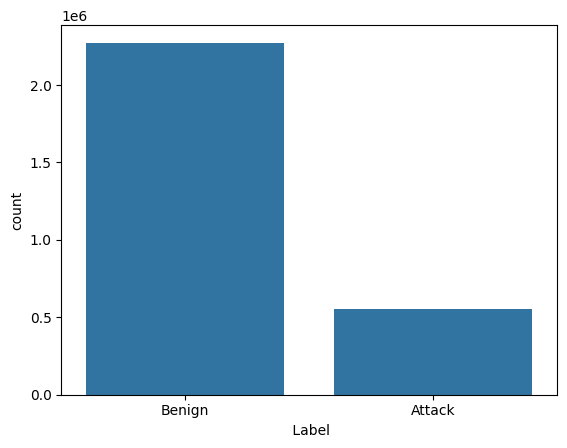

 Label
0.0    2273097
1.0     555466
Name: count, dtype: int64


In [7]:
# Plot the countplot for the 'Label' column
sns.countplot(x=' Label', data=df_data)

# Change the x-tick labels to 'Benign' for 0 and 'Attack' for 1 only in the plot
plt.gca().set_xticklabels(['Benign', 'Attack'])

# Show the plot
plt.show()

# Print the original value counts (which retains 0 and 1)
print(df_data[' Label'].value_counts())

### The label column is known to be the target
### All the previous columns are the feature matrix

In [8]:
df_data.head(5)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,33,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,0.0
1,55054,109,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,1.100917e+05,18348.62385,109.0,0.0,109,109,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,9174.311927,9174.311927,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,0.0
2,55055,52,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,2.307692e+05,38461.53846,52.0,0.0,52,52,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,19230.769230,19230.769230,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,0.0
3,46236,34,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,3.529412e+05,58823.52941,34.0,0.0,34,34,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,29411.764710,29411.764710,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,31,329,0,20,0.0,0.0,0,0,0.0,0.0,0,0,0.0
4,54863,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,32,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,0.0


In [9]:
df_data.describe()

/Users/Internship/Documents/GitHub/Capstone_Notebook/env/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/Internship/Documents/GitHub/Capstone_Notebook/env/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
count,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.829385e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2830743.0,2.830743e+06,2830743.0,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2830743.0,2830743.0,2830743.0,2830743.0,2830743.0,2830743.0,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.828563e+06
mean,8.071483e+03,1.478566e+07,9.361160e+00,1.039377e+01,5.493024e+02,1.616264e+04,2.075999e+02,1.871366e+01,5.820194e+01,6.891013e+01,8.708495e+02,4.104958e+01,3.059493e+02,3.353257e+02,inf,inf,1.298449e+06,2.919271e+06,9.182475e+06,1.623796e+05,1.448296e+07,2.610193e+06,3.266957e+06,9.042939e+06,1.021893e+06,9.893830e+06,1.805784e+06,1.485973e+06,4.684692e+06,9.672614e+05,4.644646e-02,0.0,1.112782e-04,0.0,-2.599739e+04,-2.273275e+03,6.386535e+04,6.995192e+03,1.643450e+01,9.504024e+02,1.719444e+02,2.949756e+02,4.861548e+05,3.537976e-02,4.644646e-02,2.423392e-04,2.980705e-01,3.158443e-01,9.482316e-02,1.112782e-04,2.433990e-04,6.835004e-01,1.919837e+02,5.820194e+01,3.059493e+02,-2.599739e+04,0.0,0.0,0.0,0.0,0.0,0.0,9.361160e+00,5.492919e+02,1.039377e+01,1.616230e+04,6.989837e+03,1.989433e+03,5.418218e+00,-2.741688e+03,8.155132e+04,4.113412e+04,1.531825e+05,5.829582e+04,8.316037e+06,5.038439e+05,8.695752e+06,7.920031e+06,1.963775e-01
std,1.828363e+04,3.365374e+07,7.496728e+02,9.973883e+02,9.993589e+03,2.263088e+06,7.171848e+02,6.033935e+01,1.860912e+02,2.811871e+02,1.946367e+03,6.886260e+01,6.052568e+02,8.396932e+02,NaN,NaN,4.507944e+06,8.045870e+06,2.445954e+07,2.950282e+06,3.357581e+07,9.525722e+06,9.639055e+06,2.452916e+07,8.591436e+06,2.873661e+07,8.887197e+06,6.278469e+06,1.716095e+07,8.308983e+06,2.104500e-01,0.0,1.054826e-02,0.0,2.105286e+07,1.452209e+06,2.475371e+05,3.815170e+04,2.523772e+01,2.028229e+03,3.054915e+02,6.318001e+02,1.647490e+06,1.847378e-01,2.104500e-01,1.556536e-02,4.574107e-01,4.648513e-01,2.929706e-01,1.054826e-02,1.559935e-02,6.804920e-01,3.318603e+02,1.860912e+02,6.052568e+02,2.105286e+07,0.0,0.0,0.0,0.0,0.0,0.0,7.496728e+02,9

#### we can notice from the above results that we have an outliers in the columns of Flow Bytes/s since the min has negative values

## Data Preprocessing

#### Find columns with zero variance; columns where all values are the same

In [10]:
zero_variance_cols = [col for col in df_data.columns if df_data[col].nunique() == 1]

# Display the columns with zero variance
if zero_variance_cols:
    print(f"Columns with zero variance: {zero_variance_cols}")
else:
    print("No columns with zero variance found.")

Columns with zero variance: [' Bwd PSH Flags', ' Bwd URG Flags', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']


#### Shape before removing zero variance columns

In [11]:
print('Shape before removing zero variance columns:', df_data.shape)

Shape before removing zero variance columns: (2830743, 79)


#### Handle columns with zero variance

In [12]:
if zero_variance_cols:
        df_data.drop(zero_variance_cols, axis=1, inplace=True)
        print(f'Dropped zero variance columns: {zero_variance_cols}')

Dropped zero variance columns: [' Bwd PSH Flags', ' Bwd URG Flags', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']


##### Shape after removing zero variance columns

In [13]:
print('Shape after removing zero variance columns:', df_data.shape)

Shape after removing zero variance columns: (2830743, 71)


#### Find  spaces from column names

In [14]:
df_data.keys()

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Fwd URG Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length',
       ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance',
       'FIN Flag Count', ' SYN Flag Count', 

##### Handle spaces from column names

In [15]:
df_data.columns = df_data.columns.str.strip()

#### Columns after removing spaces

In [16]:
df_data.keys()

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd URG Flags',
       'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s',
       'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count',

### Identify Rows with NaN, inf, or -inf Values
##### The row listed here contain  NaN ( Not a number) across the columns displayed.

In [17]:
# Select only numeric columns
numeric_cols = df_data.select_dtypes(include=[np.number])

# Check for inf and -inf values in the numeric columns
inf_values = np.isinf(numeric_cols).sum()

# Display the count of inf and -inf values in each numeric column
print("Count of inf and -inf values in each numeric column:")
print(inf_values)

Count of inf and -inf values in each numeric column:
Destination Port                  0
Flow Duration                     0
Total Fwd Packets                 0
Total Backward Packets            0
Total Length of Fwd Packets       0
Total Length of Bwd Packets       0
Fwd Packet Length Max             0
Fwd Packet Length Min             0
Fwd Packet Length Mean            0
Fwd Packet Length Std             0
Bwd Packet Length Max             0
Bwd Packet Length Min             0
Bwd Packet Length Mean            0
Bwd Packet Length Std             0
Flow Bytes/s                   1509
Flow Packets/s                 2867
Flow IAT Mean                     0
Flow IAT Std                      0
Flow IAT Max                      0
Flow IAT Min                      0
Fwd IAT Total                     0
Fwd IAT Mean                      0
Fwd IAT Std                       0
Fwd IAT Max                       0
Fwd IAT Min                       0
Bwd IAT Total                     0
Bwd IAT Mea

### Replace inf and -inf with Nan

In [18]:
df_data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [19]:
df_data.isna().sum()

Destination Port                  0
Flow Duration                     0
Total Fwd Packets                 0
Total Backward Packets            0
Total Length of Fwd Packets       0
Total Length of Bwd Packets       0
Fwd Packet Length Max             0
Fwd Packet Length Min             0
Fwd Packet Length Mean            0
Fwd Packet Length Std             0
Bwd Packet Length Max             0
Bwd Packet Length Min             0
Bwd Packet Length Mean            0
Bwd Packet Length Std             0
Flow Bytes/s                   2867
Flow Packets/s                 2867
Flow IAT Mean                     0
Flow IAT Std                      0
Flow IAT Max                      0
Flow IAT Min                      0
Fwd IAT Total                     0
Fwd IAT Mean                      0
Fwd IAT Std                       0
Fwd IAT Max                       0
Fwd IAT Min                       0
Bwd IAT Total                     0
Bwd IAT Mean                      0
Bwd IAT Std                 

In [20]:
print("Check for NaN values in Label column:", df_data['Label'].isna().sum())

Check for NaN values in Label column: 2180


In [21]:
df_data['Label'].value_counts()

Label
0.0    2273097
1.0     555466
Name: count, dtype: int64

In [22]:
print(df_data.isna().sum())

Destination Port                  0
Flow Duration                     0
Total Fwd Packets                 0
Total Backward Packets            0
Total Length of Fwd Packets       0
Total Length of Bwd Packets       0
Fwd Packet Length Max             0
Fwd Packet Length Min             0
Fwd Packet Length Mean            0
Fwd Packet Length Std             0
Bwd Packet Length Max             0
Bwd Packet Length Min             0
Bwd Packet Length Mean            0
Bwd Packet Length Std             0
Flow Bytes/s                   2867
Flow Packets/s                 2867
Flow IAT Mean                     0
Flow IAT Std                      0
Flow IAT Max                      0
Flow IAT Min                      0
Fwd IAT Total                     0
Fwd IAT Mean                      0
Fwd IAT Std                       0
Fwd IAT Max                       0
Fwd IAT Min                       0
Bwd IAT Total                     0
Bwd IAT Mean                      0
Bwd IAT Std                 

### Ways to handle missing values

#### This function will filter the dataframe based on NaN values in the specified columns and then calculate the value counts of the 'Label' column for these filtered rows.

In [23]:
def nan_label_counts(df_data, column_nan_list):
    # Create a mask that is True wherever any of the columns in column_nan_list have NaN values
    nan_mask = df_data[column_nan_list].isna().any(axis=1)
    
    # Filter the dataframe based on the NaN mask
    nan_rows = df_data[nan_mask]
    
    # Return the value counts of the 'Label' column in the filtered dataframe
    return nan_rows['Label'].value_counts()

# Example usage:
column_nan_list = ['Flow Bytes/s']
print(nan_label_counts(df_data, column_nan_list))


Label
0.0    1777
1.0    1090
Name: count, dtype: int64


#### Since the occurence are very low, dropping the Nan values will not have any bad effect

##### Drop rows with missing values

In [24]:
df_data.dropna(inplace=True)

In [25]:
df_data.isna().sum()

Destination Port               0
Flow Duration                  0
Total Fwd Packets              0
Total Backward Packets         0
Total Length of Fwd Packets    0
Total Length of Bwd Packets    0
Fwd Packet Length Max          0
Fwd Packet Length Min          0
Fwd Packet Length Mean         0
Fwd Packet Length Std          0
Bwd Packet Length Max          0
Bwd Packet Length Min          0
Bwd Packet Length Mean         0
Bwd Packet Length Std          0
Flow Bytes/s                   0
Flow Packets/s                 0
Flow IAT Mean                  0
Flow IAT Std                   0
Flow IAT Max                   0
Flow IAT Min                   0
Fwd IAT Total                  0
Fwd IAT Mean                   0
Fwd IAT Std                    0
Fwd IAT Max                    0
Fwd IAT Min                    0
Bwd IAT Total                  0
Bwd IAT Mean                   0
Bwd IAT Std                    0
Bwd IAT Max                    0
Bwd IAT Min                    0
Fwd PSH Fl

##### Identify duplicate rows

In [26]:
duplicate_rows = df_data[df_data.duplicated()]

if not duplicate_rows.empty:
    print("Duplicate rows:")
    print(duplicate_rows.shape)
else:
    print("No duplicate rows found.")

Duplicate rows:
(307041, 71)


##### Identify columns with identical values

In [27]:
column_pairs = []
num_columns = len(df_data.columns)

for i in range(num_columns):
    for j in range(i + 1, num_columns):
        if df_data.iloc[:, i].equals(df_data.iloc[:, j]): 
            column_pairs.append((df_data.columns[i], df_data.columns[j]))

In [28]:
print("Shape before removing identical columns:", df_data.shape)

Shape before removing identical columns: (2825696, 71)


##### Print the column pairs with identical values

In [29]:
if column_pairs:
    print("Columns with identical values:")
    for pair in column_pairs:
        print(f"{pair[0]} and {pair[1]} have identical values.")
    
    # Step 3: Drop one column from each pair
    columns_to_drop = [pair[1] for pair in column_pairs]
    df_data.drop(columns=columns_to_drop, axis=1, inplace=True)
    print(f"Dropped columns: {columns_to_drop}")
else:
    print("No columns with identical values found.")

print("Shape after removing identical columns:", df_data.shape)

Columns with identical values:
Total Fwd Packets and Subflow Fwd Packets have identical values.
Total Backward Packets and Subflow Bwd Packets have identical values.
Fwd PSH Flags and SYN Flag Count have identical values.
Fwd URG Flags and CWE Flag Count have identical values.
Fwd Header Length and Fwd Header Length.1 have identical values.
Dropped columns: ['Subflow Fwd Packets', 'Subflow Bwd Packets', 'SYN Flag Count', 'CWE Flag Count', 'Fwd Header Length.1']
Shape after removing identical columns: (2825696, 66)


#### Check for non-numeric columns

In [30]:
non_numeric_columns = df_data.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_columns)

Non-numeric columns: Index([], dtype='object')


In [31]:
df_data['Label'].unique()

array([0., 1.])

In [32]:
print(df_data['Label'].unique())

[0. 1.]


## Distribution of Network Traffic Types in the Dataset
### Before performing undersampling method

/var/folders/83/s9_py62d54b6v0352dkn68_80000gp/T/ipykernel_45165/3274448374.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['Benign', 'Attack'])


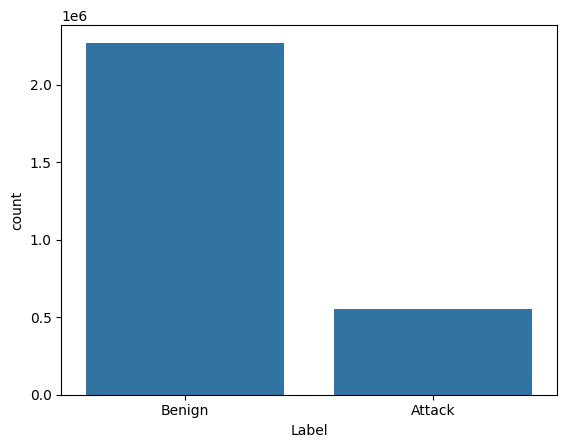

Label
0.0    2271320
1.0     554376
Name: count, dtype: int64


In [33]:
# Plot the countplot for the 'Label' column
sns.countplot(x='Label', data=df_data)

# Change the x-tick labels to 'Benign' for 0 and 'Attack' for 1 only in the plot
plt.gca().set_xticklabels(['Benign', 'Attack'])

# Show the plot
plt.show()

# Print the original value counts (which retains 0 and 1)
print(df_data['Label'].value_counts())

## Create a heatmap to visualize missing values

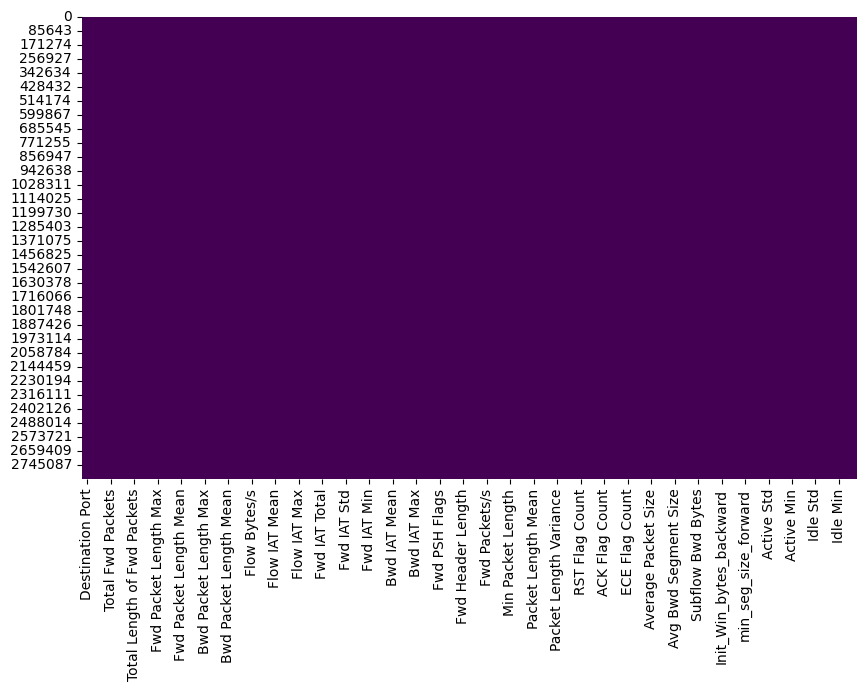

In [34]:
plt.figure(figsize=(10,6))
sns.heatmap(df_data.isnull(), cbar=False, cmap='viridis')
plt.show()

### Color: The uniform color (purple in this case) across the entire heatmap indicates consistency in the data regarding the presence or absence of missing values. Since the heatmap shows no variation in color, it tells us that there are no missing (NaN) values in any part of your DataFrame.
### Vertical Axis: Since our DataFrame likely contains a large number of rows, only some index labels are shown
### Horizontal Axis (X-axis): Displays the feature or column names of your DataFrame. All columns are represented, and the uniformity of color across all columns confirms that no columns contain missing data.

# plot before and after handling missing values

### Quantitative check to confirm that there are indeed no missing values in the dataset

In [35]:
total_missing = df_data.isnull().sum().sum()
print("Total missing values in the dataset:", total_missing)

Total missing values in the dataset: 0


## Identifying Categorical Features Based on Unique Value Counts

In [36]:
categorical_columns = []

for c in df_data.columns:
    # Check if the column is categorical (dtype of object or category) or numerical with less than 10 unique values
    if df_data[c].nunique() < 10:
        # Print unique values of columns with < 10 unique values
        print(f"Column '{c}' has unique values: {df_data[c].unique()}")
        categorical_columns.append(c)

# If you want to display the list of categorical columns with unique values < 10
print("Columns with unique values < 10:")
print(categorical_columns)

Column 'Fwd PSH Flags' has unique values: [0 1]
Column 'Fwd URG Flags' has unique values: [0 1]
Column 'FIN Flag Count' has unique values: [0 1]
Column 'RST Flag Count' has unique values: [0 1]
Column 'PSH Flag Count' has unique values: [0 1]
Column 'ACK Flag Count' has unique values: [1 0]
Column 'URG Flag Count' has unique values: [0 1]
Column 'ECE Flag Count' has unique values: [0 1]
Column 'Label' has unique values: [0. 1.]
Columns with unique values < 10:
['Fwd PSH Flags', 'Fwd URG Flags', 'FIN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'ECE Flag Count', 'Label']


### Create numerical columns list and remove the target from categorical columns

In [37]:
numerical_columns = [col for col in df_data.columns if col not in categorical_columns]
categorical_columns.remove('Label')

In [38]:
categorical_columns

['Fwd PSH Flags',
 'Fwd URG Flags',
 'FIN Flag Count',
 'RST Flag Count',
 'PSH Flag Count',
 'ACK Flag Count',
 'URG Flag Count',
 'ECE Flag Count']

In [39]:
df_data[categorical_columns].dtypes

Fwd PSH Flags     int64
Fwd URG Flags     int64
FIN Flag Count    int64
RST Flag Count    int64
PSH Flag Count    int64
ACK Flag Count    int64
URG Flag Count    int64
ECE Flag Count    int64
dtype: object

## Exploratory Data Analysis (EDA) 

## Class Distribution
### Check the distribution of the target variable (Label) to identify whether the data is balanced or imbalanced.

### Before balancing

/var/folders/83/s9_py62d54b6v0352dkn68_80000gp/T/ipykernel_45165/1327616368.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['Benign', 'Attack'])


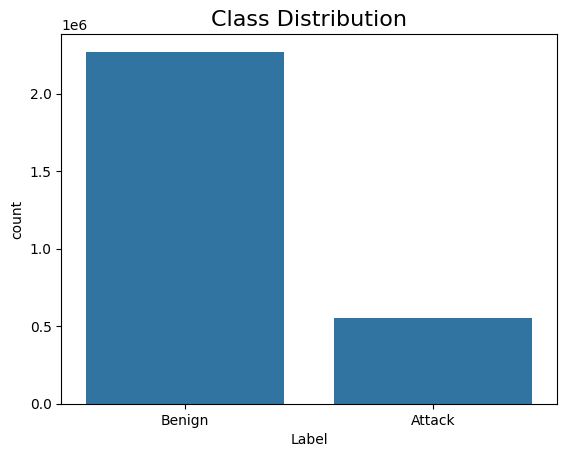

Label
0.0    2271320
1.0     554376
Name: count, dtype: int64


In [40]:
# Plot the countplot for the 'Label' column
sns.countplot(x='Label', data=df_data)

# Change the x-tick labels to 'Benign' for 0 and 'Attack' for 1 only in the plot
plt.gca().set_xticklabels(['Benign', 'Attack'])
plt.title('Class Distribution', fontsize=16)

# Show the plot
plt.show()

# Print the original value counts (which retains 0 and 1)
print(df_data['Label'].value_counts())

#### In our exploratory data analysis, we identified that our dataset is significantly imbalanced, with a larger number of 'Benign' instances compared to 'Attack'. This imbalance can lead to biased predictive models that perform well on the majority class but poorly on the minority class.

### Correlation Matrix : Blue represents negative correlations, red represents positive correlations, and white or pale colors represent no correlation.

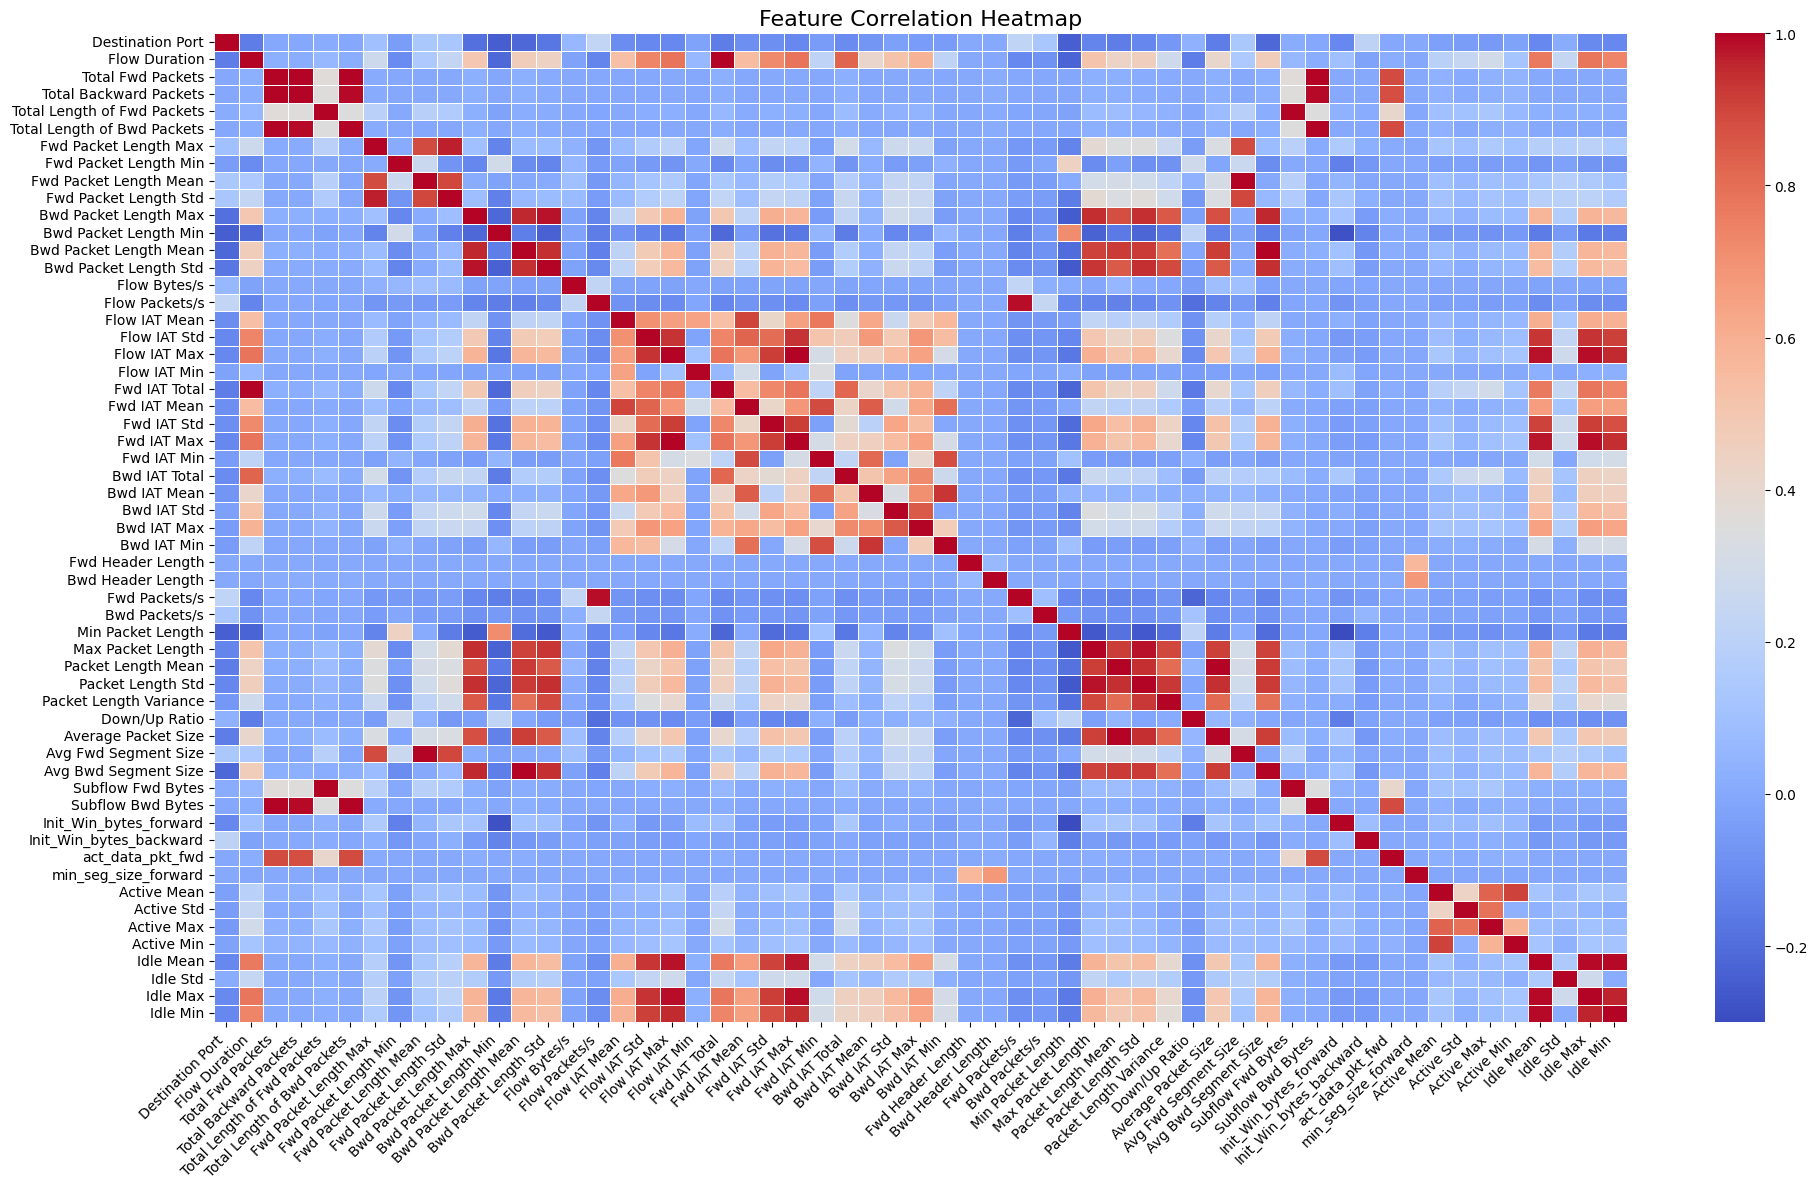

In [41]:
# Calculate the correlation matrix
corr_matrix = df_data[numerical_columns].corr()

# Plotting the heatmap with adjustments
plt.figure(figsize=(20, 12)) 
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.title('Feature Correlation Heatmap', fontsize=16)
plt.tight_layout()
plt.show()

### Since there are too many features, I focused on the most correlated features by selecting a subset. We used a threshold to filter features

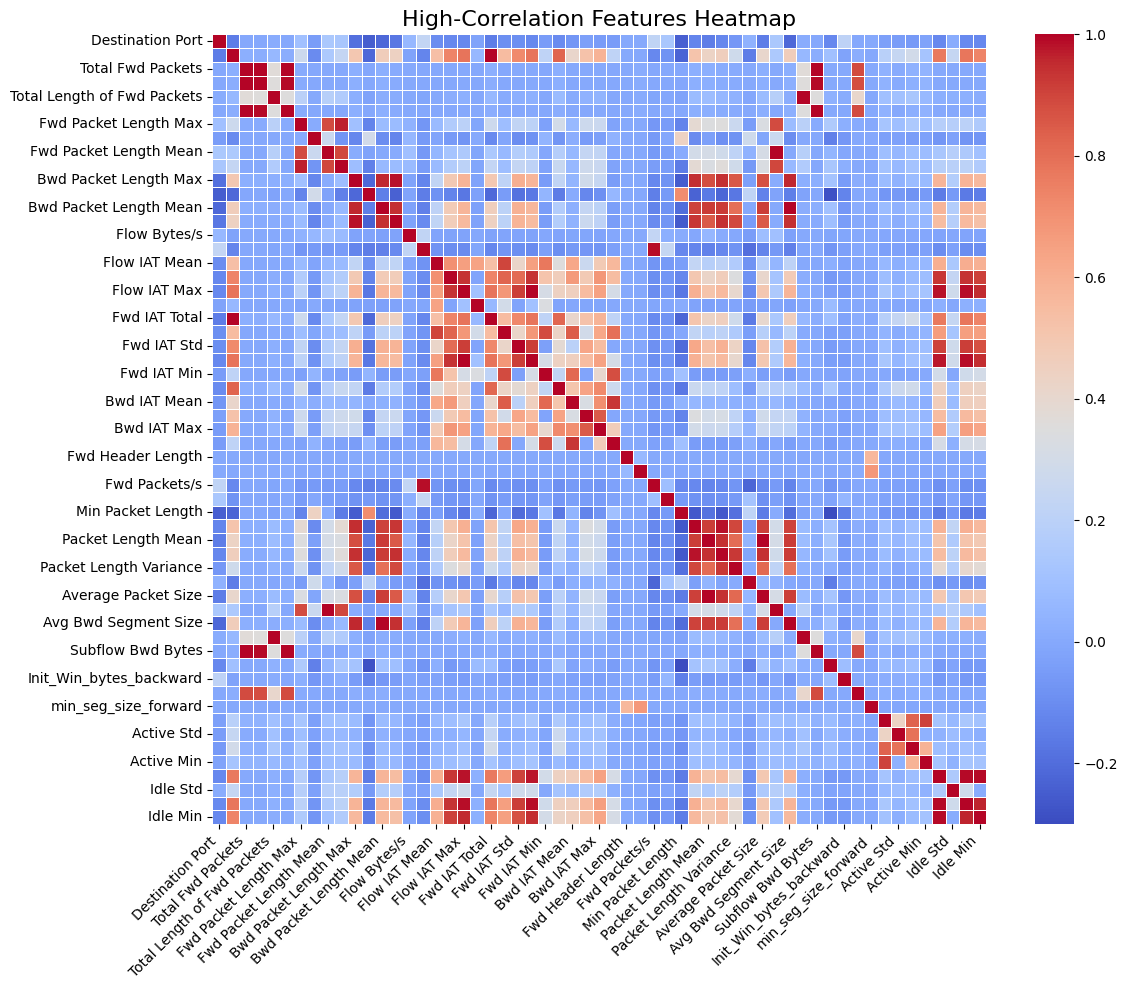

In [42]:
corr_threshold = 0.5
high_corr_features = corr_matrix.columns[(corr_matrix.abs() > corr_threshold).any()].tolist()

# Plot only the high-correlation features
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix.loc[high_corr_features, high_corr_features], annot=False, cmap='coolwarm', linewidths=0.5)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.title('High-Correlation Features Heatmap', fontsize=16)
plt.tight_layout()
plt.show()

####  This particular heatmap visualizes the relationships among various network traffic features, which are crucial for identifying patterns that might suggest normal or malicious behaviors in network traffic data.

### Tabular summary of the most and least correlated features from a correlation matrix

In [43]:
def summarize_correlations(corr_matrix, n=5):
    # Create a DataFrame from the lower triangle of the correlation matrix, excluding the diagonal
    corr_df = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(bool))
    
    # Stack the DataFrame and reset the index to turn it into a long format
    long_corr = corr_df.stack().reset_index()
    long_corr.columns = ['Feature1', 'Feature2', 'Correlation']

    # Get the top n most correlated features
    top_correlations = long_corr.nlargest(n, 'Correlation')
    
    # Get the top n least correlated features
    least_correlations = long_corr.nsmallest(n, 'Correlation')

    return top_correlations, least_correlations

# Get the summaries
top_correlations, least_correlations = summarize_correlations(corr_matrix, n=5)

# Print or return these summaries as needed
print("Top Correlations:")
print(top_correlations)
print("\nLeast Correlations:")
print(least_correlations)

Top Correlations:
                   Feature1                     Feature2  Correlation
828    Avg Fwd Segment Size       Fwd Packet Length Mean     1.000000
873    Avg Bwd Segment Size       Bwd Packet Length Mean     1.000000
951       Subflow Bwd Bytes  Total Length of Bwd Packets     1.000000
907       Subflow Fwd Bytes  Total Length of Fwd Packets     0.999999
5    Total Backward Packets            Total Fwd Packets     0.999070

Least Correlations:
                    Feature1               Feature2  Correlation
1024  Init_Win_bytes_forward      Min Packet Length    -0.300043
1001  Init_Win_bytes_forward  Bwd Packet Length Min    -0.280460
629        Max Packet Length      Min Packet Length    -0.263164
700        Packet Length Std      Min Packet Length    -0.261431
574        Min Packet Length  Bwd Packet Length Std    -0.258950


### Box Plot to Check Outliers: Box plots help identify outliers within the dataset for each feature. Box plots for each numerical column

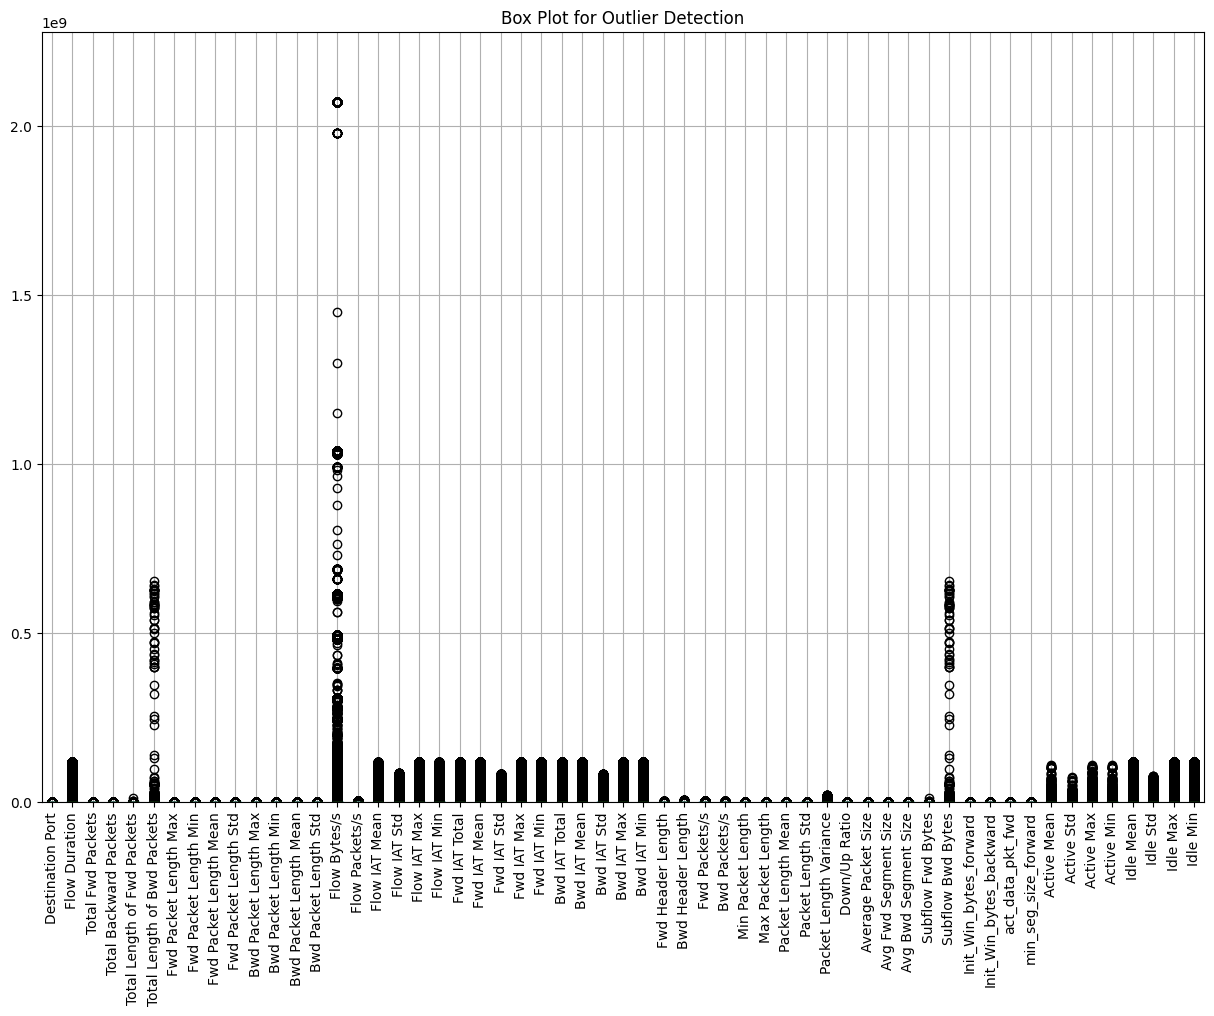

In [44]:
plt.figure(figsize=(15, 10))
df_data[numerical_columns].boxplot(rot=90)
plt.title("Box Plot for Outlier Detection")
plt.ylim(0, max(df_data[numerical_columns].max())*1.1)
plt.show()

### Focus on the "Flow Bytes/s" column only

(0.0, 2278100000.0)

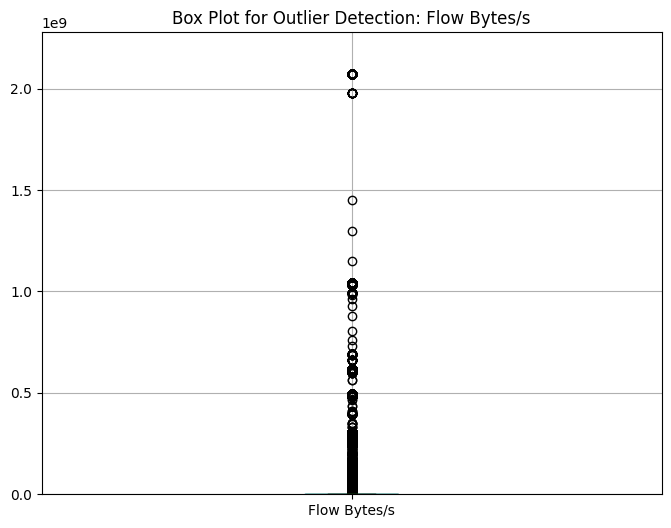

In [45]:
column_of_interest = 'Flow Bytes/s'
# Plot box plot for the selected column
plt.figure(figsize=(8, 6))
df_data[[column_of_interest]].boxplot()
plt.title(f"Box Plot for Outlier Detection: {column_of_interest}")
plt.ylim(0, df_data[column_of_interest].max() * 1.1) 

### Handle Outliers : Capping the outliers instead of removing them ensures that extreme values are still present but limited to a reasonable range
* The first quartile Q1 is the 25th percentile
* The third quartile Q3 is the 75th percentile
* Any data point that’s 1.5 points below the lower bound quartile or above the upper bound quartile is an outlier. 

In [46]:
def cap_outliers(df, col):
    Q1 = df[col].quantile(0.25) ##  The first quartile Q1 is the 25th percentile
    Q3 = df[col].quantile(0.75) ## The third quartile Q3 is the 75th percentile
    IQR = Q3 - Q1 ## The IQR is useful because it focuses on the middle 50% of the data and excludes the extreme values
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df[col] = df[col].clip(lower_bound, upper_bound)
    return df
df_data = cap_outliers(df_data, 'Flow Bytes/s')

### Box Plot after Capping Outliers

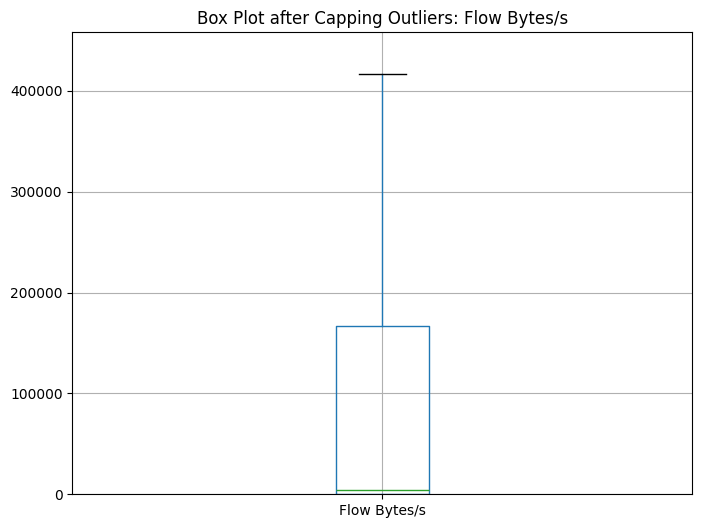

In [47]:
plt.figure(figsize=(8, 6))
df_data[[column_of_interest]].boxplot()
plt.title(f"Box Plot after Capping Outliers: {column_of_interest}")
plt.ylim(0, df_data[column_of_interest].max() * 1.1)
plt.show()

## Feature Engineering

### Data Splitting

#### Splitting of the data
#### HoldOut Validation Approach Train and test split. It means whenever we use 42 as random_state, it’ll return a shuffled dataset.

In [48]:
# Drop rows with missing values
X = df_data.drop('Label',axis=1)

# Make sure to drop corresponding rows in y
y = df_data['Label']

# Split the dataset into train and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Downsampling method

In [49]:
# Concatenate the training data back into a single DataFrame
train_data = pd.concat([X_train, y_train], axis=1)

# Separate the majority and minority classes
majority_class = train_data[train_data['Label'] == train_data['Label'].value_counts().idxmax()]
minority_class = train_data[train_data['Label'] == train_data['Label'].value_counts().idxmin()]

# Downsample the majority class to the size of the minority class
majority_class_downsampled = resample(majority_class,
                                      replace=False,    # sample without replacement
                                      n_samples=len(minority_class), # match minority class size
                                      random_state=42)

# Combine the downsampled majority class with the minority class
downsampled_train_data = pd.concat([majority_class_downsampled, minority_class])

# Separate X_train and y_train after downsampling
X_train = downsampled_train_data.drop('Label', axis=1)
y_train = downsampled_train_data['Label']

#### After performing downsampling method

/var/folders/83/s9_py62d54b6v0352dkn68_80000gp/T/ipykernel_45165/2176846930.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['Benign', 'Attack'])


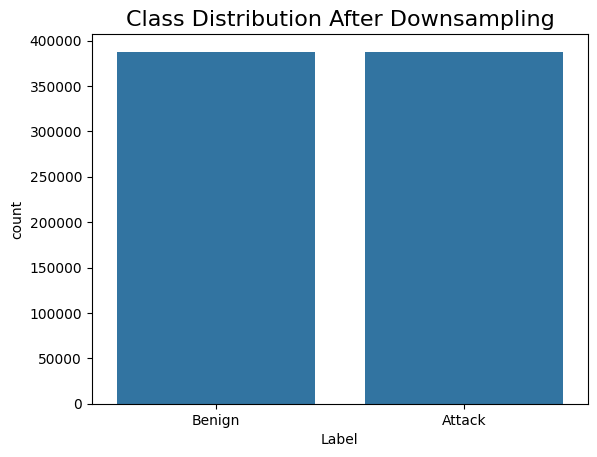

Label
0.0    387686
1.0    387686
Name: count, dtype: int64


In [50]:
# Create a DataFrame from y_train for visualization purposes
df_downsampled = pd.DataFrame({'Label': y_train})

# Plot the countplot for the downsampled 'Label' column
sns.countplot(x='Label', data=df_downsampled)

# Change the x-tick labels to 'Benign' for 0 and 'Attack' for 1 in the plot
plt.gca().set_xticklabels(['Benign', 'Attack'])
plt.title('Class Distribution After Downsampling', fontsize=16)

# Show the plot
plt.show()

# Print the downsampled value counts
print(y_train.value_counts())

In [51]:
print(df_data.columns)

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd URG Flags',
       'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s',
       'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'FIN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count',

In [52]:
df_data.shape

(2825696, 66)

### Feature Selection:

#### Feature Importance Analysis

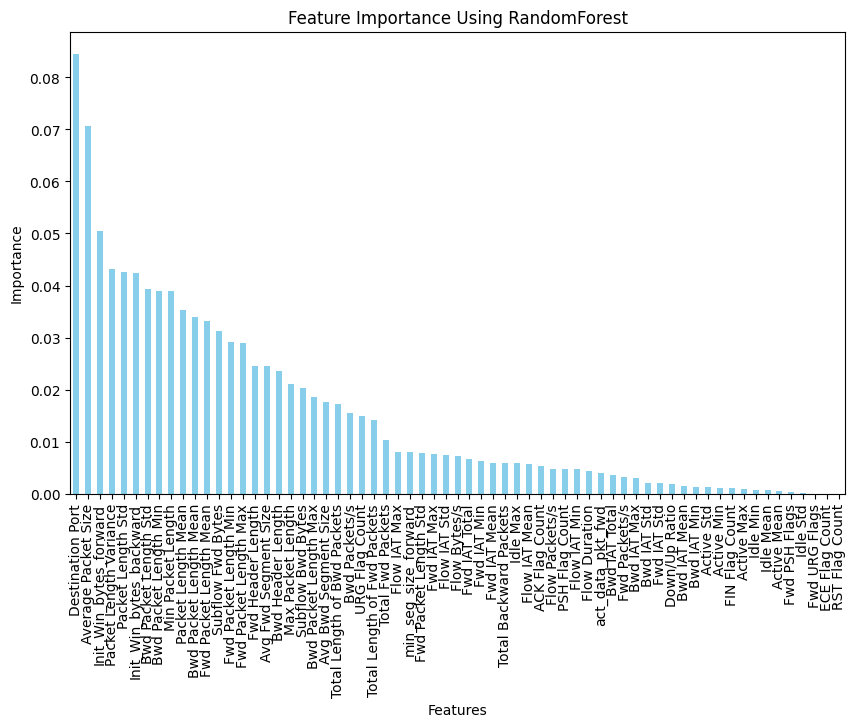

In [53]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Train the RandomForestClassifier
#rf.fit(X_train_downsampling, y_train)

rf.fit(X_train, y_train)

# Calculate feature importances
feature_importances = rf.feature_importances_

# Convert to a pandas DataFrame for easier visualization
importance_series = pd.Series(feature_importances, index=X_train.columns)

# Sort the features by importance
importance_series = importance_series.sort_values(ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
importance_series.plot(kind='bar', color='skyblue')
plt.title('Feature Importance Using RandomForest')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

#### Mutual Information

##### Calculate the importance for every feature

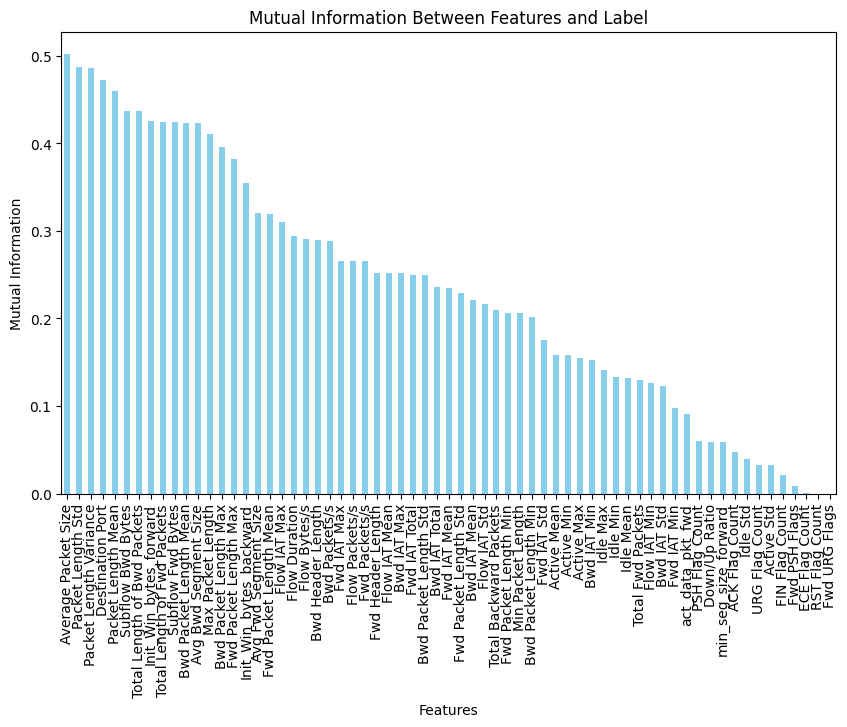

In [54]:
# Calculate mutual information between numerical features and the target
importances = mutual_info_classif(X_train, y_train)

# Convert to a pandas DataFrame for easier visualization
mi_series = pd.Series(importances, index=X.columns)

# Sort the features by importance
mi_series = mi_series.sort_values(ascending=False)

# Plot the mutual information values
plt.figure(figsize=(10, 6))
mi_series.plot(kind='bar', color='skyblue')
plt.title('Mutual Information Between Features and Label')
plt.xlabel('Features')
plt.ylabel('Mutual Information')
plt.show()

##### Calculate the sum of importance scores

In [55]:
# # Sort the feature importances along with the feature names
# f_list = sorted(zip(map(lambda x: round(x, 4), importances), X_train.columns), reverse=True) ## 

# # Initialize variables
# Sum = 0
# fs = []

# # Calculate the sum of feature importances and store features
# for i in range(len(f_list)):
#     Sum += f_list[i][0]  # Summing up the importance scores
#     fs.append(f_list[i][1])  # Append the feature name to the list

# # Optional: Print or return the feature importances and the sum
# print("Sum of feature importances:", Sum)

##### We select the important feature until the accumulated importance reaches 90%

In [56]:
# f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), X_train.columns), reverse=True)
# Sum2 = 0
# fs = []

# for i in range(0, len(f_list2)):
#     Sum2 = Sum2 + f_list2[i][0]
#     fs.append(f_list2[i][1])
    
#     if Sum2 >= 0.9:
#         break

In [57]:
# print(len(fs))
# print(fs)
feature_selected = ['Average Packet Size', 'Packet Length Variance', 'Packet Length Std', 'Destination Port', 'Packet Length Mean', 'Total Length of Bwd Packets', 'Subflow Bwd Bytes', 'Init_Win_bytes_forward', 'Total Length of Fwd Packets', 'Subflow Fwd Bytes', 'Bwd Packet Length Mean', 'Avg Bwd Segment Size', 'Max Packet Length', 'Bwd Packet Length Max', 'Fwd Packet Length Max', 'Init_Win_bytes_backward', 'Fwd Packet Length Mean', 'Avg Fwd Segment Size', 'Flow IAT Max', 'Flow Bytes/s', 'Flow Duration', 'Bwd Packets/s', 'Bwd Header Length', 'Fwd Packets/s', 'Fwd IAT Max', 'Flow Packets/s', 'Fwd Header Length', 'Flow IAT Mean', 'Bwd IAT Max', 'Fwd IAT Total', 'Bwd Packet Length Std', 'Bwd IAT Total', 'Fwd IAT Mean', 'Fwd Packet Length Std', 'Bwd IAT Mean', 'Flow IAT Std', 'Total Backward Packets', 'Fwd Packet Length Min', 'Min Packet Length', 'Bwd Packet Length Min', 'Fwd IAT Std', 'Active Min', 'Active Mean', 'Active Max']

### Standardization

#### Apply Z-Score Normalization: In our preprocessing steps, we applied Z-score normalization to our numerical features using StandardScaler. This method standardizes the features so that each has a mean of zero and a standard deviation of one, aligning with the Z-score formula.

In [58]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler only on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train[numerical_columns])

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test[numerical_columns])

#### Save the scaler to a .pkl file

In [59]:
scaler_filename = "standard_scaler.pkl"
joblib.dump(scaler, scaler_filename)

['standard_scaler.pkl']

In [60]:
numerical_columns

['Destination Port',
 'Flow Duration',
 'Total Fwd Packets',
 'Total Backward Packets',
 'Total Length of Fwd Packets',
 'Total Length of Bwd Packets',
 'Fwd Packet Length Max',
 'Fwd Packet Length Min',
 'Fwd Packet Length Mean',
 'Fwd Packet Length Std',
 'Bwd Packet Length Max',
 'Bwd Packet Length Min',
 'Bwd Packet Length Mean',
 'Bwd Packet Length Std',
 'Flow Bytes/s',
 'Flow Packets/s',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow IAT Max',
 'Flow IAT Min',
 'Fwd IAT Total',
 'Fwd IAT Mean',
 'Fwd IAT Std',
 'Fwd IAT Max',
 'Fwd IAT Min',
 'Bwd IAT Total',
 'Bwd IAT Mean',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Bwd IAT Min',
 'Fwd Header Length',
 'Bwd Header Length',
 'Fwd Packets/s',
 'Bwd Packets/s',
 'Min Packet Length',
 'Max Packet Length',
 'Packet Length Mean',
 'Packet Length Std',
 'Packet Length Variance',
 'Down/Up Ratio',
 'Average Packet Size',
 'Avg Fwd Segment Size',
 'Avg Bwd Segment Size',
 'Subflow Fwd Bytes',
 'Subflow Bwd Bytes',
 'Init_Win_bytes_forward',
 'Init_W

In [61]:
print(", ".join(numerical_columns))


Destination Port, Flow Duration, Total Fwd Packets, Total Backward Packets, Total Length of Fwd Packets, Total Length of Bwd Packets, Fwd Packet Length Max, Fwd Packet Length Min, Fwd Packet Length Mean, Fwd Packet Length Std, Bwd Packet Length Max, Bwd Packet Length Min, Bwd Packet Length Mean, Bwd Packet Length Std, Flow Bytes/s, Flow Packets/s, Flow IAT Mean, Flow IAT Std, Flow IAT Max, Flow IAT Min, Fwd IAT Total, Fwd IAT Mean, Fwd IAT Std, Fwd IAT Max, Fwd IAT Min, Bwd IAT Total, Bwd IAT Mean, Bwd IAT Std, Bwd IAT Max, Bwd IAT Min, Fwd Header Length, Bwd Header Length, Fwd Packets/s, Bwd Packets/s, Min Packet Length, Max Packet Length, Packet Length Mean, Packet Length Std, Packet Length Variance, Down/Up Ratio, Average Packet Size, Avg Fwd Segment Size, Avg Bwd Segment Size, Subflow Fwd Bytes, Subflow Bwd Bytes, Init_Win_bytes_forward, Init_Win_bytes_backward, act_data_pkt_fwd, min_seg_size_forward, Active Mean, Active Std, Active Max, Active Min, Idle Mean, Idle Std, Idle Max, I

In [62]:
X_train_scaled

array([[ 1.86420081e+00, -5.37407531e-01, -1.08193202e-02, ...,
        -1.39599848e-01, -4.81581101e-01, -4.56533798e-01],
       [ 3.34222921e+00, -5.37408164e-01, -7.54127691e-03, ...,
        -1.39599848e-01, -4.81581101e-01, -4.56533798e-01],
       [-3.82961591e-01, -5.37404231e-01, -9.18029856e-03, ...,
        -1.39599848e-01, -4.81581101e-01, -4.56533798e-01],
       ...,
       [-3.81222052e-01, -5.37409168e-01, -9.18029856e-03, ...,
        -1.39599848e-01, -4.81581101e-01, -4.56533798e-01],
       [-3.81222052e-01, -5.06057927e-01, -5.90225526e-03, ...,
        -1.39599848e-01, -4.81581101e-01, -4.56533798e-01],
       [-3.81222052e-01,  2.14444764e+00,  2.29285298e-03, ...,
        -1.39599848e-01,  2.50849981e+00,  2.63337696e+00]])

#### This code handles the integration of scaled numerical data with unscaled categorical data

In [63]:
# Convert the scaled data back into DataFrames for ease of use
# columns=numerical_columns: This specifies the column names for the new DataFrame
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numerical_columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=numerical_columns)

# axis=1 means along "columns". It's a column-wise operation.
X_train_final = pd.concat([X_train_scaled_df, X_train[categorical_columns].reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test_scaled_df, X_test[categorical_columns].reset_index(drop=True)], axis=1)

# Print the shape of the final datasets to verify the concatenation
print("X_train_final shape:", X_train_final.shape)
print("X_test_final shape:", X_test_final.shape)

X_train_final shape: (775372, 65)
X_test_final shape: (847709, 65)


### This cell represent how data are represented before being scaled

In [64]:
X_train_final.head(5)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Subflow Fwd Bytes,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Fwd PSH Flags,Fwd URG Flags,FIN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,ECE Flag Count
0,1.864201,-0.537408,-0.010819,-0.008742,-0.026048,-0.006796,-0.286561,-0.118097,-0.258956,-0.265564,-0.575614,-0.347771,-0.616781,-0.542585,0.670592,-0.177269,-0.381748,-0.488750,-0.494405,-0.055911,-0.530442,-0.378963,-0.467329,-0.489832,-0.105970,-0.338520,-0.220154,-0.263999,-0.288693,-0.100976,0.002142,0.001504,-0.210078,0.202081,-0.210083,-0.589064,-0.641982,-0.590468,-0.438364,0.530412,-0.641181,-0.258956,-0.616781,-0.026095,-0.006796,-0.493944,-0.158190,-0.008019,0.001940,-0.134643,-0.090065,-0.147904,-0.114821,-0.473644,-0.139600,-0.481581,-0.456534,0,0,0,0,0,1,1,0
1,3.342229,-0.537408,-0.007541,-0.008742,-0.024488,-0.006796,-0.243487,-0.228992,-0.230571,-0.186618,-0.575614,-0.347771,-0.616781,-0.542585,2.239712,0.072199,-0.381758,-0.488748,-0.494405,-0.055930,-0.530442,-0.378963,-0.467329,-0.489832,-0.105970,-0.338520,-0.220154,-0.263999,-0.288693,-0.100976,0.002168,0.001504,0.010240,0.447983,-0.484136,-0.580160,-0.638570,-0.575311,-0.438289,-1.016935,-0.640626,-0.230571,-0.616781,-0.024533,-0.006796,-0.456990,-0.192124,-0.005903,0.001953,-0.134643,-0.090065,-0.147904,-0.114821,-0.473644,-0.139600,-0.481581,-0.456534,0,0,0,0,0,1,0,0
2,-0.382962,-0.537404,-0.009180,-0.007494,-0.022430,-0.006716,-0.241764,0.362450,-0.088648,-0.265564,-0.549395,0.904186,-0.531166,-0.542585,2.239712,-0.213868,-0.381748,-0.488740,-0.494401,-0.055930,-0.530442,-0.378963,-0.467329,-0.489832,-0.105970,-0.338520,-0.220154,-0.263999,-0.288693,-0.100976,0.002154,0.001525,-0.228791,0.069806,0.977478,-0.563063,-0.532811,-0.561451,-0.438090,0.530412,-0.520126,-0.088648,-0.531166,-0.022471,-0.006716,-0.532320,-0.192272,-0.005903,0.001949,-0.134643,-0.090065,-0.147904,-0.114821,-0.473644,-0.139600,-0.481581,-0.456534,0,0,0,0,0,0,0,0
3,-0.357835,0.809274,0.008849,0.004977,0.027095,-0.004451,0.593875,-0.228992,0.134062,0.395630,-0.057694,-0.450672,-0.188902,-0.089758,-0.613524,-0.290662,0.045297,-0.089577,-0.194577,-0.055930,0.563081,-0.026803,-0.108804,-0.187600,-0.105944,1.473267,0.331992,0.341303,0.186175,-0.100976,0.002278,0.001719,-0.268056,-0.207748,-0.484136,-0.075451,-0.159113,-0.123813,-0.367577,-1.016935,-0.189567,0.134062,-0.188902,0.027150,-0.004451,1.652108,-0.154782,-0.001671,0.001953,0.297811,1.066384,0.959175,0.049068,-0.169104,-0.107153,-0.182274,-0.161250,0,0,0,0,1,0,0,0
4,-0.381222,-0.398653,-0.005902,-0.005000,-0.003718,-0.006331,0.309585,-0.228992,0.297820,0.502032,-0.264216,-0.416371,-0.363748,-0.188541,-0.612606,-0.290658,-0.230896,-0.306319,-0.345062,-0.055906,-0.523169,-0.369587,-0.461253,-0.484979,-0.105948,-0.155439,-0.015629,0.073519,-0.052231,-0.100950,0.002166,0.001541,-0.268054,-0.207735,-0.484136,-0.280255,-0.317882,-0.254127,-0.401591,0.530412,-0.313832,0.297820,-0.363748,-0.003722,-0.006331,0.080571,4.255755,-0.001671,0.001940,-0.134643,-0.090065,-0.147904,-0.114821,-0.473644,-0.139600,-0.481581,-0.456534,0,0,0,0,1,0,0,0


### This cell represent how data are represented after being scaled

In [65]:
X_test_final.head(5)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Subflow Fwd Bytes,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Fwd PSH Flags,Fwd URG Flags,FIN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,ECE Flag Count
0,-0.357835,-0.397277,-0.000985,-0.005000,0.013186,-0.006710,0.593875,-0.228992,0.295948,0.575624,-0.517429,-0.450672,-0.574560,-0.474087,-0.613200,-0.290656,-0.275109,-0.330125,-0.340056,-0.055918,-0.390227,-0.288580,-0.311792,-0.333500,-0.105965,-0.334109,-0.215226,-0.259214,-0.284852,-0.100940,0.002213,0.001571,-0.268052,-0.207735,-0.484136,-0.407056,-0.493538,-0.420433,-0.428966,-1.016935,-0.499025,0.295948,-0.574560,0.013213,-0.006710,1.652108,-0.141742,-0.001671,0.001953,0.103819,-0.090065,0.021140,0.145870,-0.315476,-0.1396,-0.327499,-0.297308,0,0,0,0,1,0,0,0
1,-0.382962,-0.536597,-0.010819,-0.008742,-0.022118,-0.006754,-0.178014,1.046304,0.153713,-0.265564,-0.547240,1.007086,-0.524129,-0.542585,-0.579919,-0.290428,-0.375583,-0.488750,-0.493485,-0.046568,-0.530442,-0.378963,-0.467329,-0.489832,-0.105970,-0.338520,-0.220154,-0.263999,-0.288693,-0.100976,0.002142,0.001504,-0.267936,-0.206902,2.667471,-0.560926,-0.475464,-0.580055,-0.438329,0.530412,-0.413508,0.153713,-0.524129,-0.022158,-0.006754,-0.532320,-0.192272,-0.008019,0.001940,-0.134643,-0.090065,-0.147904,-0.114821,-0.473644,-0.1396,-0.481581,-0.456534,0,0,0,0,0,0,0,0
2,-0.382962,-0.535473,-0.010819,-0.008742,-0.023927,-0.006709,-0.227980,0.510310,-0.036246,-0.265564,-0.516711,2.464844,-0.424441,-0.542585,-0.594619,-0.290565,-0.367024,-0.488750,-0.492207,-0.033597,-0.530442,-0.378963,-0.467329,-0.489832,-0.105970,-0.338520,-0.220154,-0.263999,-0.288693,-0.100976,0.002146,0.001511,-0.268006,-0.207397,1.342882,-0.530650,-0.453533,-0.505866,-0.436037,0.530412,-0.383522,-0.036246,-0.424441,-0.023971,-0.006709,-0.532320,-0.192272,-0.008019,0.001953,-0.134643,-0.090065,-0.147904,-0.114821,-0.473644,-0.1396,-0.481581,-0.456534,0,0,0,0,0,0,0,0
3,3.238823,-0.537409,-0.009180,-0.009989,-0.008957,-0.006799,0.175194,-0.118097,0.618785,0.570320,-0.577770,-0.450672,-0.623818,-0.542585,2.239712,1.523649,-0.381760,-0.488750,-0.494406,-0.055929,-0.530442,-0.378963,-0.467329,-0.489832,-0.105969,-0.338520,-0.220154,-0.263999,-0.288693,-0.100976,0.002149,0.001492,1.587253,-0.207755,-0.210083,-0.493608,-0.206600,-0.416058,-0.428476,-1.016935,-0.045899,0.618785,-0.623818,-0.008972,-0.006799,-0.527757,-0.192272,-0.005903,0.001940,-0.134643,-0.090065,-0.147904,-0.114821,-0.473644,-0.1396,-0.481581,-0.456534,1,0,0,0,0,1,0,0
4,2.258045,-0.537409,-0.007541,-0.009989,-0.024488,-0.006799,-0.243487,-0.228992,-0.230571,-0.186618,-0.577770,-0.450672,-0.623818,-0.542585,2.239712,1.886511,-0.381760,-0.488750,-0.494406,-0.055930,-0.530442,-0.378963,-0.467329,-0.489832,-0.105970,-0.338520,-0.220154,-0.263999,-0.288693,-0.100976,0.002168,0.001492,1.958314,-0.207755,-0.484136,-0.580160,-0.637717,-0.572996,-0.438265,-1.016935,-0.638220,-0.230571,-0.623818,-0.024533,-0.006799,-0.522371,-0.192272,-0.005903,0.001953,-0.134643,-0.090065,-0.147904,-0.114821,-0.473644,-0.1396,-0.481581,-0.456534,0,0,0,0,0,1,0,0


## Machine Learning Models

### Training Models on all the features
#### We perform k-fold cross validation on the entire dataset to prove that our models does not overfit

In [66]:
score = []  # For normal training results
score_hyper = []  # For hyperparameter tuning results

In [67]:
def save_best_params_to_json(model_name, best_params):
    filename= "best_params_multiple_models.json"
    # Check if the file already exists
    if os.path.exists(filename):
        # Load existing data
        with open(filename, 'r') as file:
            data = json.load(file)
    else:
        # Create a new dictionary if the file does not exist
        data = {}

    # Update the dictionary with the new model's best parameters
    data[model_name] = best_params

    # Write updated dictionary back to the JSON file
    with open(filename, 'w') as file:
        json.dump(data, file, indent=4)

In [68]:
def save_best_fs_params_to_json(model_name, best_params):
    filename= "best_params_fs_multiple_models.json"
    # Check if the file already exists
    if os.path.exists(filename):
        # Load existing data
        with open(filename, 'r') as file:
            data = json.load(file)
    else:
        # Create a new dictionary if the file does not exist
        data = {}

    # Update the dictionary with the new model's best parameters
    data[model_name] = best_params

    # Write updated dictionary back to the JSON file
    with open(filename, 'w') as file:
        json.dump(data, file, indent=4)

In [69]:
mlflow.set_tracking_uri("http://localhost:5001")

## 1. Random Forest Classifier

### Training 

In [70]:
rfc = RandomForestClassifier(random_state=42)
mlflow.set_experiment("training_all_features_binary")
mlflow.start_run(run_name="rfc_model")
mlflow.log_params(rfc.get_params())
rfc.fit(X_train_final, y_train)

RandomForestClassifier(random_state=42)

### K-Fold  Cross Validation

In [ ]:
# Define K-Fold cross-validator
kfold_validation = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the classifier
rf_cross_scores = RandomForestClassifier(random_state=42)

# Perform k-fold cross-validation with multiple scoring metrics
rf_cross_scores = cross_validate(rf_cross_scores, X, y, cv=kfold_validation, scoring='accuracy', return_train_score=True)

# Print the scores for each fold and metric
print("Average Accuracy Score:", rf_cross_scores['test_score'].mean())
print(rf_cross_scores)

### Testing

In [ ]:
# Make predictions on the test data
y_pred = rfc.predict(X_test_final)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score.append(['Random Forest', f'{accuracy:.4f}', 
    f'{recall:.4f}', 
    f'{precision:.4f}', 
    f'{f1:.4f}', 
    f'{mcc:.4f}'])

metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc}
mlflow.log_metrics(metrics)
mlflow.end_run()
# Print the results
print(f"Accuracy: {accuracy * 100:.4f}")
print(f"Recall: {recall * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"F1 Score: {f1 * 100:.4f}")
print(f"MCC: {mcc:.4f}")

### Confusion matrix

In [ ]:
# Confusion matrix
cm_rfc = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rfc, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['BENIGN', 'Attacks'], yticklabels=['BENIGN', 'Attacks'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## Let's proceed with RandomizedSearchCV
### Hyperparameter Tuning

In [ ]:
# Define parameter grid
param_dist = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=16,
    scoring='f1_weighted',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
mlflow.set_experiment("hyperparameter_tuning_all_features_binary")

# automatically starts and ends an MLflow run
mlflow.start_run(run_name="random_forest_tuned")
# Fit the RandomForest model on the training data
random_search.fit(X_train_final, y_train)

# Save the best parameters
model_name = "Random Forest"
best_params = random_search.best_params_
mlflow.log_params(best_params)

mlflow.sklearn.log_model(random_search.best_estimator_, "random_forest_model_mlflow")
save_best_params_to_json(model_name, best_params)

### Evaluation Steps

In [ ]:
# Evaluate the best model on the test set
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test_final)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score_hyper.append(['Random Forest (Tuned)', f'{accuracy:.4f}', 
    f'{recall:.4f}', 
    f'{precision:.4f}', 
    f'{f1:.4f}', 
    f'{mcc:.4f}'])
metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc}
mlflow.log_metrics(metrics)
mlflow.end_run()
# Print the results
print(f"Accuracy: {accuracy * 100:.4f}")
print(f"Recall: {recall * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"F1 Score: {f1 * 100:.4f}")
print(f"MCC: {mcc:.4f}")

### The Receiver Operating Characteristic (ROC) curve and the Area Under the Curve (AUC) are important tools for evaluating the performance of a binary classifier. The ROC curve plots the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings, providing insight into the trade-off between sensitivity (true positive rate) and specificity (false positive rate). The AUC provides a single scalar value which measures the overall ability of the model to discriminate between the positive and negative classes across all possible thresholds. Essentially, a higher AUC value indicates better model performance.

In [ ]:
# Calculate predicted probabilities for the test data using the best model from hyperparameter tuning
y_pred_prob_tuned = best_rf.predict_proba(X_test_final)[:, 1]  # Take the probability for the positive class (1)

# Compute ROC curve
fpr_tuned, tpr_tuned, thresholds_tuned = roc_curve(y_test, y_pred_prob_tuned)

# Compute AUC score
auc_tuned = roc_auc_score(y_test, y_pred_prob_tuned)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_tuned, tpr_tuned, color='blue', label='ROC Curve RandomForest (Tuned) (AUC = {:.2f})'.format(auc_tuned))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Tuned RandomForest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print the AUC
print("AUC Score Random Forest (Tuned):", auc_tuned)

In [ ]:
# Confusion matrix
cm_rfc_tuned = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rfc_tuned, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['BENIGN', 'Attacks'], yticklabels=['BENIGN', 'Attacks'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## 2. XGB

### Training

In [ ]:
# Initialize the XGBoost model
xgb = XGBClassifier(random_state=42)
mlflow.set_experiment("training_all_features_binary")
mlflow.start_run(run_name="xgb_model")
mlflow.log_params(xgb.get_params())
xgb.fit(X_train_final, y_train)

## K-fold Cross validation

In [ ]:
# Define K-Fold cross-validator
kfold_validation = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the classifier
xgb_cross = XGBClassifier(random_state=42)

# Perform k-fold cross-validation with multiple scoring metrics
xgb_cross_scores = cross_validate(xgb_cross, X, y, cv=kfold_validation, scoring='accuracy', return_train_score=True)

# Print the scores for each fold and metric
print("Average Accuracy Score:", xgb_cross_scores['test_score'].mean())
print(xgb_cross_scores)

In [80]:
# xgb_cross_scores

### Testing

In [ ]:
# Make predictions on the test data
y_pred = xgb.predict(X_test_final)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score.append(['XGB', f'{accuracy:.4f}', 
    f'{recall:.4f}', 
    f'{precision:.4f}', 
    f'{f1:.4f}', 
    f'{mcc:.4f}'])


metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc}
mlflow.log_metrics(metrics)
mlflow.end_run()
# Print the results
print(f"Accuracy: {accuracy * 100:.4f}")
print(f"Recall: {recall * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"F1 Score: {f1 * 100:.4f}")
print(f"MCC: {mcc:.4f}")

### Confusion matrix

In [ ]:
# Compute the confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['BENIGN', 'Attacks'], yticklabels=['BENIGN', 'Attacks'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

### Hyperparameter tuning

In [ ]:
mlflow.set_experiment("hyperparameter_tuning_all_features_binary")

# Define parameter grid for XGBoost
param_dist_xgb = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1]
}

# Initialize RandomizedSearchCV for XGBoost
random_search_xgb = RandomizedSearchCV(
    estimator=XGBClassifier(random_state=42),
    param_distributions=param_dist_xgb,
    n_iter=50,
    scoring='f1_weighted',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Ensure any existing runs are closed
mlflow.end_run()

# Start a new MLflow run within a context manager
mlflow.start_run(run_name="xgb_tuned")
# Fit random search to the data
random_search_xgb.fit(X_train_final, y_train)

# Retrieve and log the best parameters
best_params = random_search_xgb.best_params_
print("Best Hyperparameters for XGBoost:", best_params)
mlflow.log_params(best_params)

# Optionally log the model
mlflow.sklearn.log_model(random_search_xgb.best_estimator_, "xgb_model_mlflow")

# Save the best parameters to a JSON file (optional, not recommended within the context block)
model_name = "XGB"
save_best_params_to_json(model_name, best_params)

### Evaluation Steps

In [ ]:
# Evaluate the best XGBoost model on the test set
best_xgb = random_search_xgb.best_estimator_
y_pred = best_xgb.predict(X_test_final)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score_hyper.append(['XGB (Tuned)', f'{accuracy:.4f}', 
    f'{recall:.4f}', 
    f'{precision:.4f}', 
    f'{f1:.4f}', 
    f'{mcc:.4f}'])
metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc}
mlflow.log_metrics(metrics)
mlflow.end_run()
# Print the results
print(f"Accuracy: {accuracy * 100:.4f}")
print(f"Recall: {recall * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"F1 Score: {f1 * 100:.4f}")
print(f"MCC: {mcc:.4f}")

### The Receiver Operating Characteristic (ROC) curve and the Area Under the Curve (AUC) are important tools for evaluating the performance of a binary classifier. The ROC curve plots the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings, providing insight into the trade-off between sensitivity (true positive rate) and specificity (false positive rate). The AUC provides a single scalar value which measures the overall ability of the model to discriminate between the positive and negative classes across all possible thresholds. Essentially, a higher AUC value indicates better model performance.

In [ ]:
y_pred_prob_xgb = best_xgb.predict_proba(X_test_final)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_prob_xgb)
auc_xgb = roc_auc_score(y_test, y_pred_prob_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='green', label='ROC Curve (XGBoost) (AUC = {:.2f})'.format(auc_xgb))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Tuned XGBoost')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
print("AUC Score XGB (Tuned):", auc_xgb)

In [ ]:
cm_xgb_tuned = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb_tuned, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## 3. Decision Tree

### Training

In [ ]:
# Initialize the Decision Tree model
dt = DecisionTreeClassifier(random_state=42)
mlflow.set_experiment("training_all_features_binary")
mlflow.start_run(run_name="decision_tree")
mlflow.log_params(dt.get_params())
dt.fit(X_train_final, y_train)

## k- fold cross

In [ ]:
# Define K-Fold cross-validator
kfold_validation = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the classifier
DT_cross = DecisionTreeClassifier(random_state=42)

# Perform k-fold cross-validation with multiple scoring metrics
DT_cross_scores = cross_validate(DT_cross, X, y, cv=kfold_validation, scoring='accuracy', return_train_score=True)

# Print the scores for each fold and metric
print("Average Accuracy Score:", DT_cross_scores['test_score'].mean())
print(DT_cross_scores)

In [89]:
# DT_cross_scores

### Testing

In [ ]:
# Make predictions on the test data
y_pred_dt = dt.predict(X_test_final)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score.append(['Decision Tree ', f'{accuracy:.4f}', 
    f'{recall:.4f}', 
    f'{precision:.4f}', 
    f'{f1:.4f}', 
    f'{mcc:.4f}'])

metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc}
mlflow.log_metrics(metrics)
mlflow.end_run()
# Print the results
print(f"Accuracy: {accuracy * 100:.4f}")
print(f"Recall: {recall * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"F1 Score: {f1 * 100:.4f}")
print(f"MCC: {mcc:.4f}")

### Confusion Matrix

In [ ]:
# Compute the confusion matrix for Decision Tree
cm_dt = confusion_matrix(y_test, y_pred_dt)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['BENIGN', 'Attacks'], yticklabels=['BENIGN', 'Attacks'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

### Hyperparameter Tuning

In [ ]:
# Define parameter grid for Decision Tree
param_dist_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'splitter': ['best', 'random']
}

# Initialize RandomizedSearchCV for Decision Tree
random_search_dt = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions=param_dist_dt,
    n_iter=50,  # Adjusted number of iterations
    scoring='f1_weighted',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Set the MLflow tracking URI and experiment
mlflow.set_experiment("hyperparameter_tuning_all_features_binary")

# Ensure any existing runs are closed
mlflow.end_run()

# Start a new MLflow run within a context manager
mlflow.start_run(run_name="decision_tree_tuned")
# Fit random search to the data
random_search_dt.fit(X_train_final, y_train)

# Retrieve and log the best parameters
best_params = random_search_dt.best_params_
print("Best Hyperparameters for Decision Tree:", best_params)
mlflow.log_params(best_params)

# Optionally log the model
mlflow.sklearn.log_model(random_search_dt.best_estimator_, "Decision_Tree_model_mlflow")

# Save the best parameters to a JSON file (optional, not recommended within the context block)
model_name = "Decision Tree"
save_best_params_to_json(model_name, best_params)

### Evaluation Steps

In [ ]:
best_dt = random_search_dt.best_estimator_
y_pred = best_dt.predict(X_test_final)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score_hyper.append(['Decision Tree (Tuned)', f'{accuracy:.4f}', 
    f'{recall:.4f}', 
    f'{precision:.4f}', 
    f'{f1:.4f}', 
    f'{mcc:.4f}'])
metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc}
mlflow.log_metrics(metrics)
mlflow.end_run()
# Print the results
print(f"Accuracy: {accuracy * 100:.4f}")
print(f"Recall: {recall * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"F1 Score: {f1 * 100:.4f}")
print(f"MCC: {mcc:.4f}")

### The Receiver Operating Characteristic (ROC) curve and the Area Under the Curve (AUC) are important tools for evaluating the performance of a binary classifier. The ROC curve plots the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings, providing insight into the trade-off between sensitivity (true positive rate) and specificity (false positive rate). The AUC provides a single scalar value which measures the overall ability of the model to discriminate between the positive and negative classes across all possible thresholds. Essentially, a higher AUC value indicates better model performance.

In [ ]:
y_pred_prob_dt = best_dt.predict_proba(X_test_final)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_prob_dt)
auc_dt = roc_auc_score(y_test, y_pred_prob_dt)

plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, color='purple', label='ROC Curve (Decision Tree) (AUC = {:.2f})'.format(auc_dt))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Tuned Decision Tree')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
print("AUC Score Decision Tree(Tuned):", auc_dt)

In [ ]:
cm_dt_tuned = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt_tuned, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

### 4. Logistic Regression: While simpler, logistic regression can still provide solid results, especially when regularized using techniques like L2 (Ridge) or L1 (Lasso).

### Training

In [ ]:
# Initialize the Logistic Regression model
lr = LogisticRegression(random_state=42)
mlflow.set_experiment("training_all_features_binary")
mlflow.start_run(run_name="logistic_regression")
mlflow.log_params(lr.get_params())
lr.fit(X_train_final, y_train)

## k-fold cross validation

In [ ]:
# Define K-Fold cross-validator
kfold_validation = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the classifier
lr_cross = LogisticRegression(random_state=42)

# Perform k-fold cross-validation with multiple scoring metrics
lr_cross_scores = cross_validate(lr_cross, X, y, cv=kfold_validation, scoring='accuracy', return_train_score=True)

# Print the scores for each fold and metric
print("Average Accuracy Score:", lr_cross_scores['test_score'].mean())
print(lr_cross_scores)

In [98]:
# lr_cross_scores

### Testing

In [ ]:
# Make predictions on the test data
y_pred = lr.predict(X_test_final)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score.append(['Logistic Regression', f'{accuracy:.4f}', 
    f'{recall:.4f}', 
    f'{precision:.4f}', 
    f'{f1:.4f}', 
    f'{mcc:.4f}'])

metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc }
mlflow.log_metrics(metrics)
mlflow.end_run()
# Print the results
print(f"Accuracy: {accuracy * 100:.4f}")
print(f"Recall: {recall * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"F1 Score: {f1 * 100:.4f}")
print(f"MCC: {mcc:.4f}")

### Confusion matrix

In [ ]:
# Compute the confusion matrix
cm_lr = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['BENIGN', 'Attacks'], yticklabels=['BENIGN', 'Attacks'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

### Hyperparameter Tuning

In [ ]:
# Define the parameter grid for Logistic Regression
param_grid = {
    'penalty': ['l2'],           # Simplified to only 'l2' for now to reduce complexity
    'C': [0.1, 1.0],             # Reduced range for C
    'solver': ['liblinear'],     # Using 'liblinear' as it's often faster for smaller datasets
    'max_iter': [1000],          # Standard max_iter to see if it converges
    'tol': [1e-4]                # Standard tolerance
}

# Initialize the Logistic Regression model
log_model = LogisticRegression(random_state=42)

# Initialize GridSearchCV
clf = GridSearchCV(log_model, param_grid=param_grid, cv=3, verbose=True, n_jobs=-1, scoring='f1_weighted')

mlflow.set_experiment("hyperparameter_tuning_all_features_binary")

# Ensure any existing runs are closed
mlflow.end_run()

# Start a new MLflow run within a context manager
mlflow.start_run(run_name="logistic_regression_tuned")
# Fit GridSearchCV to the data
clf.fit(X_train_final, y_train)

# Retrieve and log the best parameters
best_params = clf.best_params_
print("Best parameters found: ", best_params)
print("Best cross-validated score: ", clf.best_score_)

# Log the best parameters
mlflow.log_params(best_params)

# Optionally log the model
mlflow.sklearn.log_model(clf.best_estimator_, "logistic_regression_model_mlflow")

# Save the best parameters to a JSON file
model_name = "Logistic Regression"
save_best_params_to_json(model_name, best_params)

### Evaluation Steps

In [ ]:
# Get the best model from GridSearchCV
best_lr = clf.best_estimator_

# Validating the model with training data (optional)
train_score = best_lr.score(X_train_final, y_train)
print(f'Accuracy on training set: {train_score:.3f}')

# Testing the best logistic regression model (after hyperparameter tuning)
y_pred = best_lr.predict(X_test_final)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

# Append the results to the hyperparameter-tuned score list
score_hyper.append([
    'Logistic Regression (Tuned)', 
    f'{accuracy:.4f}', 
    f'{recall:.4f}', 
    f'{precision:.4f}', 
    f'{f1:.4f}', 
    f'{mcc:.4f}'
])
metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc }
mlflow.log_metrics(metrics)
# End the MLflow run
mlflow.end_run()
# Print the results
print(f"Accuracy: {accuracy * 100:.4f}")
print(f"Recall: {recall * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"F1 Score: {f1 * 100:.4f}")
print(f"MCC: {mcc:.4f}")

### The Receiver Operating Characteristic (ROC) curve and the Area Under the Curve (AUC) are important tools for evaluating the performance of a binary classifier. The ROC curve plots the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings, providing insight into the trade-off between sensitivity (true positive rate) and specificity (false positive rate). The AUC provides a single scalar value which measures the overall ability of the model to discriminate between the positive and negative classes across all possible thresholds. Essentially, a higher AUC value indicates better model performance.

In [ ]:
y_pred_prob_lr = best_lr.predict_proba(X_test_final)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_prob_lr)
auc_lr = roc_auc_score(y_test, y_pred_prob_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='orange', label='ROC Curve (Logistic Regression) (AUC = {:.2f})'.format(auc_lr))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Tuned Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
print("AUC Score Logistic Regression (Tuned):", auc_lr)

In [ ]:
# Compute the confusion matrix for tuned Logistic Regression
cm_lr_tuned = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr_tuned, annot=True, cmap='Blues', fmt='g', xticklabels=['BENIGN', 'Attacks'], yticklabels=['BENIGN', 'Attacks'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## 5. CatBoost Model:
* CatBoost is preferred when dealing with datasets containing categorical features, as it automatically handles them without preprocessing. 
* It also offers built-in methods for handling missing values and is robust to overfitting. 
### Training

### Training

In [ ]:
catboost = CatBoostClassifier(verbose=0, random_state=42)
mlflow.set_experiment("training_all_features_binary")
mlflow.start_run(run_name="catboost_default", nested=True)
mlflow.log_params(catboost.get_params())
catboost.fit(X_train_final, y_train)

## k-fold cross validation

In [ ]:
# Define K-Fold cross-validator
kfold_validation = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the classifier
catBoost_cross = CatBoostClassifier()

# Perform k-fold cross-validation with multiple scoring metrics
catBoost_cross_scores = cross_validate(catBoost_cross, X, y, cv=kfold_validation, scoring='accuracy', return_train_score=True)

# Print the scores for each fold and metric
print("Average Accuracy Score:", catBoost_cross_scores['test_score'].mean())
print(catBoost_cross_scores)

### Testing

In [ ]:
# Make predictions on the test data
y_pred = catboost.predict(X_test_final)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score.append(['CatBoost', f'{accuracy:.4f}', 
    f'{recall:.4f}', 
    f'{precision:.4f}', 
    f'{f1:.4f}', 
    f'{mcc:.4f}'])

metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc, }
mlflow.log_metrics(metrics)
mlflow.end_run()
# Print the results
print(f"Accuracy: {accuracy * 100:.4f}")
print(f"Recall: {recall * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"F1 Score: {f1 * 100:.4f}")
print(f"MCC: {mcc:.4f}")

### Confusion Matrix

In [ ]:
cm_catboost = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_catboost, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['BENIGN', 'Attacks'], yticklabels=['BENIGN', 'Attacks'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

### Hyperparameter Tuning

In [ ]:
param_grid_catboost = {
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [500, 1000, 1500],
    'l2_leaf_reg': [1, 3, 5]
}

random_search_catboost = RandomizedSearchCV(
    estimator=CatBoostClassifier(verbose=0, random_state=42),
    param_distributions=param_grid_catboost,
    n_iter=10,  # Number of parameter settings to sample (adjustable)
    scoring='f1_weighted',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Set the MLflow tracking URI and experiment
mlflow.set_experiment("hyperparameter_tuning_all_features_binary")

# Ensure any existing runs are closed
mlflow.end_run()

# Start a new MLflow run within a context manager
mlflow.start_run(run_name="CatBoost_tuned")
# Fit RandomizedSearchCV to the data
random_search_catboost.fit(X_train_final, y_train)

# Retrieve and log the best parameters
best_params = random_search_catboost.best_params_
print("Best Hyperparameters for CatBoost:", best_params)
mlflow.log_params(best_params)

# Optionally log the model
mlflow.sklearn.log_model(random_search_catboost.best_estimator_, "CatBoost_model_mlflow")

# Save the best parameters to a JSON file (optional, not recommended within the context block)
model_name = "CatBoost"
save_best_params_to_json(model_name, best_params)

## Evaluation steps

In [ ]:
best_catboost = random_search_catboost.best_estimator_
y_pred = best_catboost.predict(X_test_final)


accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

# Append to the score_hyper list
score_hyper.append(['CatBoost (Tuned)', f'{accuracy:.4f}', 
    f'{recall:.4f}', 
    f'{precision:.4f}', 
    f'{f1:.4f}', 
    f'{mcc:.4f}'])
metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc}
mlflow.log_metrics(metrics)
mlflow.end_run()
# Print the results
print(f"Accuracy: {accuracy * 100:.4f}")
print(f"Recall: {recall * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"F1 Score: {f1 * 100:.4f}")
print(f"MCC: {mcc:.4f}")

### The Receiver Operating Characteristic (ROC) curve and the Area Under the Curve (AUC) are important tools for evaluating the performance of a binary classifier. The ROC curve plots the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings, providing insight into the trade-off between sensitivity (true positive rate) and specificity (false positive rate). The AUC provides a single scalar value which measures the overall ability of the model to discriminate between the positive and negative classes across all possible thresholds. Essentially, a higher AUC value indicates better model performance.

In [ ]:
y_pred_prob_catboost = best_catboost.predict_proba(X_test_final)[:, 1]
fpr_catboost, tpr_catboost, _ = roc_curve(y_test, y_pred_prob_catboost)
auc_catboost = roc_auc_score(y_test, y_pred_prob_catboost)

plt.figure(figsize=(8, 6))
plt.plot(fpr_catboost, tpr_catboost, color='cyan', label='ROC Curve Cat Boost (AUC = {:.2f})'.format(auc_catboost))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Tuned Catboost')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
print("AUC Score CatBoost:", auc_catboost)

In [ ]:
cm_catboost_tunned = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_catboost_tunned, annot=True, cmap='Blues', fmt='g',
            xticklabels=['BENIGN', 'Attacks'], yticklabels=['BENIGN', 'Attacks'])
plt.title('Catboost Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## DataFrames for Model Metrics:

### After collecting the results in score and score_hyper , I have created a new DataFrames to display the results (accuracy, recall, etc.), as shown below

In [113]:
# Define the columns for the tables
columns = ['Model', 'Accuracy', 'Recall', 'Precision', 'F1 Score', 'MCC']

# Create a DataFrame for the normal training results
df_normal = pd.DataFrame(score, columns=columns)

# Create a DataFrame for the hyperparameter tuning results
df_hyper = pd.DataFrame(score_hyper, columns=columns)

In [ ]:
print("Normal Training Results:")
df_normal

In [ ]:
print("\nHyperparameter Tuning Results:")
df_hyper

### Save df_normal as a PNG

In [116]:
from pandas.plotting import table

# Assuming df_normal is your DataFrame
df_normal = df_normal.reset_index(drop=True)  # Reset and drop the index

fig, ax = plt.subplots(figsize=(10, 2))  # Set the figure size as needed
ax.axis('tight')
ax.axis('off')

# Create a table without the index
tbl = table(ax, df_normal, loc='center', cellLoc='center')  # Create a table
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)  # Adjust font size if needed
tbl.scale(1.2, 1.2)  # Scale the table
plt.title('Comparison of Classification Model Metrics Before Hyperparameter Tuning')

# Save the figure as a PNG file
plt.savefig('df_normal_table.png')
plt.close()

### Save df_hyper as a PNG

In [117]:
fig, ax = plt.subplots(figsize=(10, 2))  # Set the figure size as needed
ax.axis('tight')
ax.axis('off')
tbl = table(ax, df_hyper, loc='center', cellLoc='center')  # Create a table
tbl.auto_set_font_size(False)
tbl.set_fontsize(8)  # Adjust font size if needed
tbl.scale(1.2, 1.2)  # Scale the table
plt.title('Comparison of Classification Model Metrics After Hyperparameter Tuning')

plt.savefig('df_hyper_table.png')  # Save the figure as a PNG file
plt.close()

## Plot and Save Multiple Confusion Matrices

In [ ]:
# Define the confusion matrices and titles in tuples for easier handling
confusion_matrices = [
    (cm_rfc_tuned, "Random Forest"),
    (cm_xgb_tuned, "XGBoost"),
    (cm_lr_tuned, "Logistic Regression"),
    (cm_dt_tuned, "Decision Tree"),
    (cm_catboost_tunned, "CatBoost")
]

# Setup the matplotlib figure and axes
num_matrices = len(confusion_matrices)
fig, axes = plt.subplots(nrows=1, ncols=num_matrices, figsize=(5 * num_matrices, 5))  # Adjust size as needed

# Check if only one row of subplots, make axes iterable
if num_matrices == 1:
    axes = [axes]

# Loop through the confusion matrices and corresponding axes
for ax, (cm, title) in zip(axes, confusion_matrices):
    # Plotting the confusion matrix using seaborn's heatmap function
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', ax=ax, 
                xticklabels=['BENIGN', 'Attacks'], yticklabels=['BENIGN', 'Attacks'])
    ax.set_title(title)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

# Tight layout to ensure subplots do not overlap
plt.tight_layout()

# Save the figure
plt.savefig('all_confusion_matrices.png')
plt.show()

In [ ]:
print(catBoost_cross_scores)
print(lr_cross_scores)
print(DT_cross_scores)
print(xgb_cross_scores)
print(rf_cross_scores)

## K-fold cross-validation

In [ ]:
# Assuming the cross-validation score data is correct as provided
models = ['CatBoost', 'Logistic Regression', 'Decision Tree', 'XGBoost', 'Random Forest']
results = {
    'Model': models,
    'Fold-1': [scores['test_score'][0] for scores in [catBoost_cross_scores, lr_cross_scores, DT_cross_scores, xgb_cross_scores, rf_cross_scores]],
    'Fold-2': [scores['test_score'][1] for scores in [catBoost_cross_scores, lr_cross_scores, DT_cross_scores, xgb_cross_scores, rf_cross_scores]],
    'Fold-3': [scores['test_score'][2] for scores in [catBoost_cross_scores, lr_cross_scores, DT_cross_scores, xgb_cross_scores, rf_cross_scores]],
    'Fold-4': [scores['test_score'][3] for scores in [catBoost_cross_scores, lr_cross_scores, DT_cross_scores, xgb_cross_scores, rf_cross_scores]],
    'Fold-5': [scores['test_score'][4] for scores in [catBoost_cross_scores, lr_cross_scores, DT_cross_scores, xgb_cross_scores, rf_cross_scores]]
}

df_results = pd.DataFrame(results)

# Avoid converting to strings, calculate mean and standard deviation directly
df_results['Mean Accuracy'] = df_results[['Fold-1', 'Fold-2', 'Fold-3', 'Fold-4', 'Fold-5']].mean(axis=1)
df_results['Standard Deviation'] = df_results[['Fold-1', 'Fold-2', 'Fold-3', 'Fold-4', 'Fold-5']].std(axis=1)

# Formatting the output for display (not altering the actual DataFrame)
formatted_df = df_results.copy()
formatted_df.iloc[:, 1:] = formatted_df.iloc[:, 1:].map(lambda x: f"{x:.4f}")

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('tight')
ax.axis('off')

# Creating the table
table = ax.table(cellText=formatted_df.values, colLabels=formatted_df.columns, cellLoc='center', loc='center', colWidths=[0.15, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.13])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

# Add a title
plt.title('Cross-Validation Results for Various Models')

# Save the figure
plt.savefig('Cross Validation table.png')

# Display the plot
plt.show()

## Save All ROC curve

In [ ]:
plt.figure(figsize=(12, 8))

plt.plot(fpr_tuned, tpr_tuned, color='blue', label='Random Forest (AUC = {:.2f})'.format(auc_tuned))
plt.plot(fpr_xgb, tpr_xgb, color='green', label='XGBoost (AUC = {:.2f})'.format(auc_xgb))
plt.plot(fpr_dt, tpr_dt, color='purple', label='Decision Tree (AUC = {:.2f})'.format(auc_dt))
plt.plot(fpr_lr, tpr_lr, color='orange', label='Logistic Regression (AUC = {:.2f})'.format(auc_lr))
plt.plot(fpr_catboost, tpr_catboost, color='cyan', label='CatBoost (AUC = {:.2f})'.format(auc_catboost))

plt.plot([0, 1], [0, 1], 'k--')  # Random chance
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of ROC Curves for All Tuned Models')
plt.legend(loc='lower right')
plt.grid(True)

# Save the combined plot
plt.savefig('all_roc_curves.png')
plt.show()

# ------------------------------------------Feature Selected-----------------------------------------------

# Training models with features selected

In [122]:
X_train_fs = X_train_final[feature_selected]
X_test_fs = X_test_final[feature_selected]

In [123]:
score_fs = []  # For normal training results
score_hyper_fs = []  # For hyperparameter tuning results

## 1. Random Forest Classifier

### Training 

In [ ]:
rfc_fs = RandomForestClassifier(random_state=42)
mlflow.set_experiment("training_all_features_binary_fs")
mlflow.start_run(run_name="rfc_fs_model")
mlflow.log_params(rfc_fs.get_params())
rfc_fs.fit(X_train_fs, y_train)

### Testing

In [ ]:
y_pred = rfc_fs.predict(X_test_fs)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score_fs.append(['Random Forest', 
    f'{accuracy:.4f}', 
    f'{recall:.4f}', 
    f'{precision:.4f}', 
    f'{f1:.4f}', 
    f'{mcc:.4f}'])

metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc}
mlflow.log_metrics(metrics)
mlflow.end_run()


print(f"Accuracy: {accuracy * 100:.4f}")
print(f"Recall: {recall * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"F1 Score: {f1 * 100:.4f}")
print(f"MCC: {mcc:.4f}")

### Confusion matrix

In [ ]:
cm_rf = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['BENIGN', 'Attacks'], yticklabels=['BENIGN', 'Attacks'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

### Hyperparameter Tuning

1. n_estimators: A higher number of trees generally improves model performance but also increases computation time. We chose 50 and 100 to have a balance between performance and speed.
2. max_depth: max_depth is None, the nodes will expand until all leaves are pure or until they contain fewer samples than min_samples_split. Limiting the depth (e.g., to 10) helps control overfitting by restricting the complexity of the trees.
3. min_samples_split: This parameter prevents trees from growing too deep and helps reduce overfitting. We included 2 as the minimum (default value) and 5 to encourage larger splits that might generalize better.
4. min_samples_leaf: This controls the size of leaf nodes in the trees. Setting it to 2 means that a split won't happen if a node has fewer than two samples, helping to reduce the risk of creating leaves with very few samples (which can cause overfitting)
5. bootstrap: Using bootstrap sampling (True) means that some samples might be used multiple times to build individual trees, which generally leads to more robust models. Without bootstrapping (False), all data points are used to train each tree, which can sometimes lead to faster convergence.

In [ ]:
# Define parameter grid
param_dist = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=100,
    scoring='f1_weighted',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
mlflow.set_experiment("hyperparameter_tuning_fs_binary")
mlflow.end_run()

mlflow.start_run(run_name="random_forest_fs_tuned")
# Fit random search to the data
random_search.fit(X_train_fs, y_train)

# Print best parameters
print("Best Hyperparameters:", random_search.best_params_)

# Save the best parameters
model_name = "Random Forest fs"
best_params = random_search.best_params_
mlflow.log_params(best_params)

# Optionally log the model as well
mlflow.sklearn.log_model(random_search.best_estimator_, "random_forest_fs_model_mlflow")

save_best_fs_params_to_json(model_name, best_params)

### Evaluation Steps

In [ ]:
# Evaluate the best model on the test set
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test_fs)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score_hyper_fs.append(['Random Forest (Tuned)', f'{accuracy:.4f}', 
    f'{recall:.4f}', 
    f'{precision:.4f}', 
    f'{f1:.4f}', 
    f'{mcc:.4f}'])
metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc}
mlflow.log_metrics(metrics)
# End the MLflow run
mlflow.end_run()
# Print the results
print(f"Accuracy: {accuracy * 100:.4f}")
print(f"Recall: {recall * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"F1 Score: {f1 * 100:.4f}")
print(f"MCC: {mcc:.4f}")

In [ ]:
cm_rfc_fs_tunned = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rfc_fs_tunned, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

### ROC Curves for RandomForest

In [ ]:
# Predict probabilities for the test data using the best Random Forest model
y_pred_prob_rf_fs = best_rf.predict_proba(X_test_fs)[:, 1]

# Compute ROC curve
fpr_rf_fs, tpr_rf_fs, _ = roc_curve(y_test, y_pred_prob_rf_fs)

# Compute AUC score
auc_rf_fs = roc_auc_score(y_test, y_pred_prob_rf_fs)

# Plot the ROC curve for Random Forest
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf_fs, tpr_rf_fs, color='blue', label='Random Forest FS (AUC = {:.2f})'.format(auc_rf_fs))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Tuned RandomForest with Feature Selection')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## 2. XGB

### Training

In [ ]:
# Initialize the XGBoost model
xgb_fs = XGBClassifier(random_state=42)
mlflow.set_experiment("training_all_features_binary_fs")
mlflow.start_run(run_name="xgb_fs_model")
mlflow.log_params(xgb_fs.get_params())
xgb_fs.fit(X_train_fs, y_train)

In [ ]:
# Make predictions on the test data
y_pred = xgb_fs.predict(X_test_fs)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score_fs.append(['XGB Model', f'{accuracy:.4f}', 
    f'{recall:.4f}', 
    f'{precision:.4f}', 
    f'{f1:.4f}', 
    f'{mcc:.4f}'])
metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc}
mlflow.log_metrics(metrics)
# End the MLflow run
mlflow.end_run()
# Print the results
print(f"Accuracy: {accuracy * 100:.4f}")
print(f"Recall: {recall * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"F1 Score: {f1 * 100:.4f}")
print(f"MCC: {mcc:.4f}")

In [ ]:
# Compute the confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['BENIGN', 'Attacks'], yticklabels=['BENIGN', 'Attacks'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## Hyperparameter Tuning

In [ ]:
# Define parameter grid for XGBoost
param_dist_xgb = {
    'n_estimators': [50, 100],  # Reduced to 2 values
    'learning_rate': [0.05, 0.1],  # Reduced to 2 values
    'max_depth': [3, 5],  # Reduced to 2 values
    'subsample': [0.8, 1.0],  # Reduced to 2 values
    'colsample_bytree': [0.8, 1.0],  # Reduced to 2 values
    'gamma': [0, 0.1]  # Reduced to 2 values
}

# Initialize RandomizedSearchCV for XGBoost
random_search_xgb = RandomizedSearchCV(
    estimator=XGBClassifier(random_state=42),
    param_distributions=param_dist_xgb,
    n_iter=50,
    scoring='f1_weighted',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
mlflow.set_experiment("hyperparameter_tuning_fs_binary")
mlflow.end_run()
mlflow.start_run(run_name="xgb_fs_tuned")

# Fit random search to the data
random_search_xgb.fit(X_train_fs, y_train)


# Save the best parameters
model_name = "XGB fs"

best_params = random_search.best_params_
mlflow.log_params(best_params)

# Optionally log the model as well
mlflow.sklearn.log_model(random_search.best_estimator_, "xgb_model_fs_mlflow")


save_best_fs_params_to_json(model_name, best_params)

# Print best parameters for XGBoost
print("Best Hyperparameters for XGBoost:", random_search_xgb.best_params_)

In [ ]:
# Evaluate the best XGBoost model on the test set
best_xgb = random_search_xgb.best_estimator_
y_pred = best_xgb.predict(X_test_fs)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score_hyper_fs.append(['XGB (Tuned)', f'{accuracy:.4f}', 
    f'{recall:.4f}', 
    f'{precision:.4f}', 
    f'{f1:.4f}', 
    f'{mcc:.4f}'])
metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc}
mlflow.log_metrics(metrics)
# End the MLflow run
mlflow.end_run()
# Print the results
print(f"Accuracy: {accuracy * 100:.4f}")
print(f"Recall: {recall * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"F1 Score: {f1 * 100:.4f}")
print(f"MCC: {mcc:.4f}")

## ROC for XGB

In [ ]:
# Predict probabilities for the test data using the best XGBoost model
y_pred_prob_xgb_fs = best_xgb.predict_proba(X_test_fs)[:, 1]

# Compute ROC curve
fpr_xgb_fs, tpr_xgb_fs, _ = roc_curve(y_test, y_pred_prob_xgb_fs)

# Compute AUC score
auc_xgb_fs = roc_auc_score(y_test, y_pred_prob_xgb_fs)

# Plot the ROC curve for XGBoost
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb_fs, tpr_xgb_fs, color='green', label='XGBoost FS (AUC = {:.2f})'.format(auc_xgb_fs))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Tuned XGBoost with Feature Selection')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
# Compute the confusion matrix
cm_xgb_fs_tunned = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb_fs_tunned, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['BENIGN', 'Attacks'], yticklabels=['BENIGN', 'Attacks'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## 3. logistic regression

In [ ]:
# Initialize the Logistic Regression model
lr_fs = LogisticRegression(random_state=42)
mlflow.set_experiment("training_all_features_binary_fs")
mlflow.start_run(run_name="logistic_regression_fs")
mlflow.log_params(lr_fs.get_params())
lr_fs.fit(X_train_fs, y_train)

## Testing

In [ ]:
# Make predictions on the test data
y_pred = lr_fs.predict(X_test_fs)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score_fs.append(['Logistic Regression', f'{accuracy:.4f}', 
    f'{recall:.4f}', 
    f'{precision:.4f}', 
    f'{f1:.4f}', 
    f'{mcc:.4f}'])

metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc, }
mlflow.log_metrics(metrics)
mlflow.end_run()
# Print the results
print(f"Accuracy: {accuracy * 100:.4f}")
print(f"Recall: {recall * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"F1 Score: {f1 * 100:.4f}")
print(f"MCC: {mcc:.4f}")

In [ ]:
cm_lr_fs = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr_fs, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['BENIGN', 'Attacks'], yticklabels=['BENIGN', 'Attacks'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## Hyperparameter Tuning

In [ ]:
# Define the parameter grid for Logistic Regression
param_grid = {
    'penalty': ['l2'],           # Simplified to only 'l2' for now to reduce complexity
    'C': [0.1, 1.0],             # Reduced range for C
    'solver': ['liblinear'],     # Using 'liblinear' as it's often faster for smaller datasets
    'max_iter': [1000],          # Standard max_iter to see if it converges
    'tol': [1e-4]                # Standard tolerance
}

# Initialize the Logistic Regression model
log_model = LogisticRegression(random_state=42)

# Initialize GridSearchCV
clf = GridSearchCV(log_model, param_grid=param_grid, cv=3, verbose=True, n_jobs=-1, scoring='f1_weighted')
mlflow.set_experiment("hyperparameter_tuning_fs_binary")
mlflow.end_run()
mlflow.start_run(run_name="logistic_regression_fs_tuned")
# Apply best hyperparameters by fitting the model
clf.fit(X_train_fs, y_train)

# Check out the best parameters found by GridSearchCV
print("Best parameters found: ", clf.best_params_)
print("Best cross-validated score: ", clf.best_score_)

# Save the best parameters
model_name = "Logistic Regression tunned fs"

best_params = clf.best_params_
print("Best Hyperparameters for LogisticRegression:", best_params)
mlflow.log_params(best_params)
mlflow.sklearn.log_model(random_search.best_estimator_, "lr_model_fs_mlflow")
save_best_fs_params_to_json(model_name, best_params)

In [ ]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

# Append the results to the hyperparameter-tuned score list
score_hyper_fs.append(['Logistic Regression (Tuned)', f'{accuracy:.4f}', 
    f'{recall:.4f}', 
    f'{precision:.4f}', 
    f'{f1:.4f}', 
    f'{mcc:.4f}'])
metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc}
mlflow.log_metrics(metrics)
# End the MLflow run
mlflow.end_run()
# Print the results
print(f"Accuracy: {accuracy * 100:.4f}")
print(f"Recall: {recall * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"F1 Score: {f1 * 100:.4f}")
print(f"MCC: {mcc:.4f}")

In [ ]:
# Example to check if feature sets match
print("Features used to fit the model:", clf.best_estimator_.feature_names_in_)
print("Features in test set:", X_test_fs.columns.tolist())

## ROC for Logistic Regression

In [ ]:
y_pred_prob_lr_fs = clf.predict_proba(X_test_fs)[:, 1]
fpr_lr_fs, tpr_lr_fs, _ = roc_curve(y_test, y_pred_prob_lr_fs)
auc_lr_fs = roc_auc_score(y_test, y_pred_prob_lr_fs)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr_fs, tpr_lr_fs, color='orange', label='ROC Curve (Logistic Regression) (AUC = {:.2f})'.format(auc_lr_fs))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Tuned Logistic Regression with Feature Selection')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
# Compute the confusion matrix
cm_lr_fs_tunned = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr_fs_tunned, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['BENIGN', 'Attacks'], yticklabels=['BENIGN', 'Attacks'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## 4. Catboost

## Training

In [ ]:
catboost_fs = CatBoostClassifier(verbose=0, random_state=42)
mlflow.set_experiment("training_all_features_binary_fs")
mlflow.start_run(run_name="catboost_default", nested=True)
mlflow.log_params(catboost_fs.get_params())
catboost_fs.fit(X_train_fs, y_train)

## Testing

In [ ]:
# Make predictions on the test data
y_pred = catboost_fs.predict(X_test_fs)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score_fs.append(['CatBoost', f'{accuracy:.4f}', 
    f'{recall:.4f}', 
    f'{precision:.4f}', 
    f'{f1:.4f}', 
    f'{mcc:.4f}'])

metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc, }
mlflow.log_metrics(metrics)
mlflow.end_run()
# Print the results
print(f"Accuracy: {accuracy * 100:.4f}")
print(f"Recall: {recall * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"F1 Score: {f1 * 100:.4f}")
print(f"MCC: {mcc:.4f}")

## confusion matrix

In [ ]:
cm_catboost_fs = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_catboost_fs, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['BENIGN', 'Attacks'], yticklabels=['BENIGN', 'Attacks'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## Hyperparameter tuning

In [ ]:
# Hyperparameter Tuning with GridSearchCV
param_grid_catboost = {
    'depth': [6, 10],  # reduced from [6, 8, 10]
    'learning_rate': [0.01, 0.1],  # reduced from [0.01, 0.05, 0.1]
    'iterations': [1000],  # fixed at the higher value
    'l2_leaf_reg': [1, 5],  # reduced from [1, 3, 5, 7]
    'border_count': [32, 128]  # reduced from [32, 64, 128]
}


grid_search_catboost = GridSearchCV(
    estimator=CatBoostClassifier(verbose=0, random_state=42),
    param_grid=param_grid_catboost,
    scoring='f1_weighted',
    cv=3,
    verbose=2,
    n_jobs=-1
)
mlflow.set_experiment("hyperparameter_tuning_fs_binary")
mlflow.end_run()

# Start a new MLflow run within a context manager
mlflow.start_run(run_name="CatBoost_tuned")
# Fit RandomizedSearchCV to the data
grid_search_catboost.fit(X_train_fs, y_train)

# Retrieve and log the best parameters
best_params = grid_search_catboost.best_params_
print("Best Hyperparameters for CatBoost:", best_params)
mlflow.log_params(best_params)

# Optionally log the model
mlflow.sklearn.log_model(grid_search_catboost.best_estimator_, "CatBoost_model_mlflow")

# Save the best parameters to a JSON file (optional, not recommended within the context block)
model_name = "CatBoost fs"
save_best_fs_params_to_json(model_name, best_params)

## evaluation matrix

In [ ]:
best_catboost = grid_search_catboost.best_estimator_
y_pred = best_catboost.predict(X_test_fs)


accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

# Append to the score_hyper list
score_hyper_fs.append(['CatBoost fs (Tuned)', f'{accuracy:.4f}', 
    f'{recall:.4f}', 
    f'{precision:.4f}', 
    f'{f1:.4f}', 
    f'{mcc:.4f}'])
metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc}
mlflow.log_metrics(metrics)
# End the MLflow run
mlflow.end_run()
# Print the results
print(f"Accuracy: {accuracy * 100:.4f}")
print(f"Recall: {recall * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"F1 Score: {f1 * 100:.4f}")
print(f"MCC: {mcc:.4f}")

## ROC for Catboost

In [ ]:
y_test_binary = (y_test == 1).astype(int)

# Calculate predicted probabilities for the class of interest
y_pred_prob_tuned = best_catboost.predict_proba(X_test_final)[:, 1]  # Index for class 1

# Compute ROC curve and AUC score for the binary case
fpr_catboost, tpr_catboost, thresholds_tuned = roc_curve(y_test_binary, y_pred_prob_tuned)
auc_catboost = roc_auc_score(y_test_binary, y_pred_prob_tuned)
# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_catboost, tpr_catboost, color='blue', label=f'ROC Curve Cat Boost (AUC = {auc_catboost:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Tuned CatBoost')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
print("AUC Score CatBoost:", auc_catboost)

In [ ]:
cm_catboost_fs_tuned= confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_catboost_fs_tuned, annot=True, cmap='Blues', fmt='g',
            xticklabels=['BENIGN', 'Attacks'], yticklabels=['BENIGN', 'Attacks'])
plt.title('Catboost fs Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## 5. Decision Tree

## Training

In [ ]:
dt_fs = DecisionTreeClassifier(random_state=42)
mlflow.set_experiment("training_all_features_binary_fs")
mlflow.start_run(run_name="decision_tree_fs")
mlflow.log_params(dt_fs.get_params())
dt_fs.fit(X_train_fs, y_train)

## Testing

In [ ]:
# Make predictions on the test data
y_pred_dt = dt_fs.predict(X_test_fs)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score_fs.append(['Decision Tree model', f'{accuracy:.4f}', 
    f'{recall:.4f}', 
    f'{precision:.4f}', 
    f'{f1:.4f}', 
    f'{mcc:.4f}'])

metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc}
mlflow.log_metrics(metrics)
mlflow.end_run()
# Print the results
print(f"Accuracy: {accuracy * 100:.4f}")
print(f"Recall: {recall * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"F1 Score: {f1 * 100:.4f}")
print(f"MCC: {mcc:.4f}")

## confusin matrix

In [ ]:
# Compute the confusion matrix for Decision Tree
cm_dt_fs = confusion_matrix(y_test, y_pred_dt)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt_fs, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['BENIGN', 'Attacks'], yticklabels=['BENIGN', 'Attacks'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## hyperparameter tuning

In [ ]:
# Define parameter grid for Decision Tree
param_dist_dt = {
    'criterion': ['gini', 'entropy'],  # Criterion to split at nodes
    'max_depth': [None, 10, 20, 30],  # Depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split
    'min_samples_leaf': [1, 2, 4],  # Minimum samples per leaf node
    'max_features': [None, 'sqrt', 'log2'],  # Maximum features considered at each split
    'splitter': ['best', 'random']  # Split strategy
}
# Initialize RandomizedSearchCV for Decision Tree
random_search_dt = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions=param_dist_dt,
    n_iter=50,  # You can adjust this number
    scoring='f1_weighted',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
mlflow.set_experiment("hyperparameter_tuning_fs_binary")
mlflow.end_run()
mlflow.start_run(run_name="decision_tree_fs_tuned")
# Fit random search to the data
random_search_dt.fit(X_train_fs, y_train)
# Save the best parameters
model_name = "Decision Tree fs"

best_params = random_search_dt.best_params_
# Print best parameters for Decision Tree
print("Best Hyperparameters for Decision Tree fs:", random_search_dt.best_params_)

mlflow.log_params(best_params)

# Optionally log the model as well
mlflow.sklearn.log_model(random_search.best_estimator_, "Decision_Tree_model_fs_mlflow")

save_best_fs_params_to_json(model_name, best_params)

In [ ]:
best_dt = random_search_dt.best_estimator_
y_pred = best_dt.predict(X_test_fs)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score_hyper_fs.append(['Decision Tree (Tuned)', f'{accuracy:.4f}', 
    f'{recall:.4f}', 
    f'{precision:.4f}', 
    f'{f1:.4f}', 
    f'{mcc:.4f}'])
metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc}
mlflow.log_metrics(metrics)
# End the MLflow run
mlflow.end_run()
# Print the results
print(f"Accuracy: {accuracy * 100:.4f}")
print(f"Recall: {recall * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"F1 Score: {f1 * 100:.4f}")
print(f"MCC: {mcc:.4f}")

## ROC

In [ ]:
# Predict probabilities for the test data using the best Decision Tree model
y_pred_prob_dt_fs = best_dt.predict_proba(X_test_fs)[:, 1]

# Compute ROC curve
fpr_dt_fs, tpr_dt_fs, _ = roc_curve(y_test, y_pred_prob_dt_fs)

# Compute AUC score
auc_dt_fs = roc_auc_score(y_test, y_pred_prob_dt_fs)

# Plot the ROC curve for Decision Tree
plt.figure(figsize=(8, 6))
plt.plot(fpr_dt_fs, tpr_dt_fs, color='orange', label='Decision Tree FS (AUC = {:.2f})'.format(auc_dt_fs))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Tuned Decision Tree with Feature Selection')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
# Compute the confusion matrix for Decision Tree
cm_dt_fs_tunned = confusion_matrix(y_test, y_pred_dt)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt_fs_tunned, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['BENIGN', 'Attacks'], yticklabels=['BENIGN', 'Attacks'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## Save confusion matrix fs

In [ ]:
# Define the confusion matrices and titles in tuples for easier handling
confusion_matrices = [
    (cm_rfc_fs_tunned, "Random Forest"),
    (cm_xgb_fs_tunned, "XGBoost"),
    (cm_lr_fs_tunned, "Logistic Regression"),
    (cm_dt_fs_tunned, "Decision Tree"),
    (cm_catboost_fs_tuned, "CatBoost")
]

# Setup the matplotlib figure and axes
num_matrices = len(confusion_matrices)
fig, axes = plt.subplots(nrows=1, ncols=num_matrices, figsize=(5 * num_matrices, 5))  # Adjust size as needed

# Check if only one row of subplots, make axes iterable
if num_matrices == 1:
    axes = [axes]

# Loop through the confusion matrices and corresponding axes
for ax, (cm, title) in zip(axes, confusion_matrices):
    # Plotting the confusion matrix using seaborn's heatmap function
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', ax=ax, 
                xticklabels=['BENIGN', 'Attacks'], yticklabels=['BENIGN', 'Attacks'])
    ax.set_title(title)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

# Tight layout to ensure subplots do not overlap
plt.tight_layout()

# Save the figure
plt.savefig('all_confusion_matrices_fs.png')
plt.show()

## Save All ROC curve

In [ ]:
plt.figure(figsize=(12, 8))

# Plot the ROC curves for each model
plt.plot(fpr_rf_fs, tpr_rf_fs, color='blue', label='Random Forest FS (AUC = {:.2f})'.format(auc_rf_fs))
plt.plot(fpr_xgb_fs, tpr_xgb_fs, color='green', label='XGBoost FS (AUC = {:.2f})'.format(auc_xgb_fs))
plt.plot(fpr_dt_fs, tpr_dt_fs, color='purple', label='Decision Tree FS (AUC = {:.2f})'.format(auc_dt_fs))
plt.plot(fpr_lr_fs, tpr_lr_fs, color='orange', label='Logistic Regression FS (AUC = {:.2f})'.format(auc_lr_fs))
plt.plot(fpr_catboost, tpr_catboost, color='cyan', label='CatBoost FS (AUC = {:.2f})'.format(auc_catboost))

# Plot random chance line (the diagonal)
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of ROC Curves for All Tuned Models with Feature Selected')

# Add legend
plt.legend(loc='lower right')

# Add grid
plt.grid(True)

# Save the combined plot
plt.savefig('all_roc_curves_fs.png')

# Display the plot
plt.show()

## DataFrames for Model Metrics:

### After collecting the results in score_fs and score_hyper_fs , I have created a new DataFrames to display the results (accuracy, recall, etc.), as shown below

In [162]:
# Define the columns for the tables
columns = ['Model', 'Accuracy', 'Recall', 'Precision', 'F1 Score', 'MCC']

# Create a DataFrame for the normal training results
df_normal_fs = pd.DataFrame(score_fs, columns=columns)

# Create a DataFrame for the hyperparameter tuning results
df_hyper_fs = pd.DataFrame(score_hyper_fs, columns=columns)

In [ ]:
print("Normal Training Feature Selected Results:")
df_normal_fs

In [ ]:
print("\nHyperparameter Tuning Feature Selected  Results:")
df_hyper_fs

## Save the figure as a PNG file

In [166]:
from pandas.plotting import table

In [167]:
df_normal_fs = df_normal_fs.reset_index(drop=True)  # Reset and drop the index

fig, ax = plt.subplots(figsize=(10, 2))  # Set the figure size as needed
ax.axis('tight')
ax.axis('off')
tbl = table(ax, df_normal, loc='center', cellLoc='center')  # Create a table
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)  # Adjust font size if needed
tbl.scale(1.2, 1.2)  # Scale the table
plt.title('Comparison of Classification Model Metrics Before Hyperparameter Tuning with Feature Selected')

plt.savefig('df_normal_fs_table.png')  # Save the figure as a PNG file
plt.close()

In [194]:
df_hyper_fs_no_index = df_hyper_fs.copy()

# Adjusting the plot code to ensure no index is shown
fig, ax = plt.subplots(figsize=(10, 2))
ax.axis('tight')
ax.axis('off')

tbl = table(ax, df_hyper_fs_no_index, loc='center', cellLoc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(8)
tbl.scale(1.2, 1.2)

# Add title
plt.title('Hyperparameter Tuning Feature Selected: Results (Index Removed)')

# Save the figure
plt.savefig('df_hyper_fs_table.png')
plt.close()